# **Importing library&function**






In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, mean_squared_error, auc
from IPython.core.display import display, HTML
import numpy as np
import time
import os
from google.colab import drive
import itertools

!pip install split_folders
import splitfolders

!pip install scikit-learn

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls /content/drive/MyDrive/ColabNotebooks/FinalProject/Dataset/grayscale/
import splitfolders
import os
loc = "/content/drive/MyDrive/ColabNotebooks/FinalProject/Dataset/grayscale/"
# csvloc = "/content/drive/MyDrive/ColabNotebooks/FinalProject/Result/"

gray_cataract  gray_diabetic_retinopathy  gray_glaucoma  gray_normal


In [4]:
import os
splitfolders.ratio(loc,output = "outputgrayscale",ratio = (0.90,0.05,0.05))
for dirpath,dirname,filename in os.walk("./outputgrayscale"):
  print(f"There are {len(dirname)} directories and {len(filename)} images in '{dirpath}'.")

Copying files: 4238 files [00:56, 75.15 files/s] 

There are 3 directories and 0 images in './outputgrayscale'.
There are 4 directories and 0 images in './outputgrayscale/val'.
There are 0 directories and 52 images in './outputgrayscale/val/gray_cataract'.
There are 0 directories and 53 images in './outputgrayscale/val/gray_normal'.
There are 0 directories and 54 images in './outputgrayscale/val/gray_diabetic_retinopathy'.
There are 0 directories and 50 images in './outputgrayscale/val/gray_glaucoma'.
There are 4 directories and 0 images in './outputgrayscale/train'.
There are 0 directories and 943 images in './outputgrayscale/train/gray_cataract'.
There are 0 directories and 966 images in './outputgrayscale/train/gray_normal'.
There are 0 directories and 989 images in './outputgrayscale/train/gray_diabetic_retinopathy'.
There are 0 directories and 915 images in './outputgrayscale/train/gray_glaucoma'.
There are 4 directories and 0 images in './outputgrayscale/test'.
There are 0 directories and 53 images in './outputgrayscale/test/gray

In [5]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",patience = 6,
                                             min_delta = 0.0001)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss",factor = 0.2,
                                                patience = 4,min_lr = 1e-7)

In [6]:
data_aug = tf.keras.Sequential([
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomFlip("horizontal")
],name = "data_augmentation_layer")

In [7]:
def predict_labels(model, X_test):
    return model.predict(X_test)

def display_classification_report(y_test, y_pred):
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

def calculate_specificity(y_test, y_pred):
    # tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    # specificity = tn / (tn + fp)
    # print(f"Specificity: {specificity}")
    cm = confusion_matrix(y_test, y_pred)
    specificity = []
    for i in range(cm.shape[0]):
      spec = cm[i, i] / (np.sum(cm[i, :]) - cm[i, i] + np.sum(cm[:, :]) - np.sum(cm[i, :]))
      specificity.append(spec)
    print(f"Specificity: {specificity}")

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
    # Create the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # normalize
    n_classes = cm.shape[0]  # find the number of classes

    specificity = []  # To store specificity values for each class

    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    ax.set(
        title="Confusion Matrix",
        xlabel="Predicted label",
        ylabel="True label",
        xticks=np.arange(n_classes),
        yticks=np.arange(n_classes),
        xticklabels=labels,
        yticklabels=labels
    )

    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    plt.xticks(rotation=70, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    threshold = (cm.max() + cm.min()) / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        specificity_val = (cm.sum() - cm[i].sum() - cm[:, j].sum() + cm[i, j]) / (
            cm.sum() - cm[:, j].sum()
        )
        specificity.append(specificity_val)

        if norm:
            plt.text(
                j,
                i,
                f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%,\n {specificity_val*100:.1f}%)",
                #  f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%, Specificity: {specificity_val*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size,
            )
        else:
            plt.text(
                j,
                i,
                f"{cm[i, j]} ( {specificity_val*100:.1f}%)",
                #  f"{cm[i, j]} (Specificity: {specificity_val*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size,
            )

    if savefig:
        fig.savefig("confusion_matrix.png")

    return specificity

def calculate_mse(y_test, y_probs, n_classes):
  y_true_onehot = tf.keras.utils.to_categorical(y_test, n_classes)
  mse = mean_squared_error(y_true_onehot, y_probs)
  print(f"Mean Squared Error: : {mse}")
  return y_true_onehot

def calculate_roc_auc_score(y_test, y_probs):
  auc_roc = roc_auc_score(y_test, y_probs, multi_class='ovr', average=None)
  average_auc_roc = np.mean(auc_roc)
  print(f"The average AUC-ROC is {average_auc_roc}")

In [8]:
def sharpen_image(image, factor=1.5):
    adjusted = tf.image.adjust_contrast(image, factor)
    return adjusted

# **Batch size: 16**

In [9]:
epoch = 20
batchsize = 16

In [38]:
train_dir = "outputgrayscale/train"
test_dir =  "outputgrayscale/test"
val_dir = "outputgrayscale/val"

train_classes = sorted([name for name in os.listdir(train_dir)])
class_names = train_classes  # Assuming class names are the same across train, test, and val

# Load datasets
train_data = image_dataset_from_directory(train_dir, label_mode="categorical",
                                          image_size=(224, 224), batch_size=batchsize,
                                          shuffle=True, seed=42, color_mode='grayscale')

test_data = image_dataset_from_directory(test_dir, label_mode="categorical",
                                         image_size=(224, 224), batch_size=batchsize,
                                         shuffle=False, seed=42, color_mode='grayscale')

val_data = image_dataset_from_directory(val_dir, label_mode="categorical",
                                        image_size=(224, 224), batch_size=batchsize,
                                        shuffle=False, seed=42, color_mode='grayscale')


Found 3813 files belonging to 4 classes.
Found 216 files belonging to 4 classes.
Found 209 files belonging to 4 classes.


In [39]:
class_names = train_data.class_names  # Store class names before transformations

# Apply transformations using map() function
train_data = train_data.map(lambda x, y: (sharpen_image(x), y))
test_data = test_data.map(lambda x, y: (sharpen_image(x), y))
val_data = val_data.map(lambda x, y: (sharpen_image(x), y))


# **EfficientNetV2B3 Model**

In [40]:
efficient_model = tf.keras.applications.EfficientNetV2B3(include_top = False)
efficient_model.trainable = False


In [41]:
inputs = layers.Input(shape=(224, 224, 1), name="input_layer")
x = data_aug(inputs)
# x = inputs
x = efficient_model(x)

# Apply Global Average Pooling
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(32, activation="relu", kernel_initializer=tf.keras.initializers.he_normal())(x)
x = layers.Dense(4)(x)
outputs = layers.Activation("softmax", dtype=tf.float32)(x)

efficient_model = tf.keras.Model(inputs, outputs)
efficient_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 1)]     0         
                                                                 
 data_augmentation_layer (S  (None, None, None, 1)     0         
 equential)                                                      
                                                                 
 efficientnetv2-b3 (Functio  (None, None, None, 1536   12930622  
 nal)                        )                                   
                                                                 
 global_average_pooling2d_3  (None, 1536)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_9 (Dense)             (None, 32)                49184     
                                                           

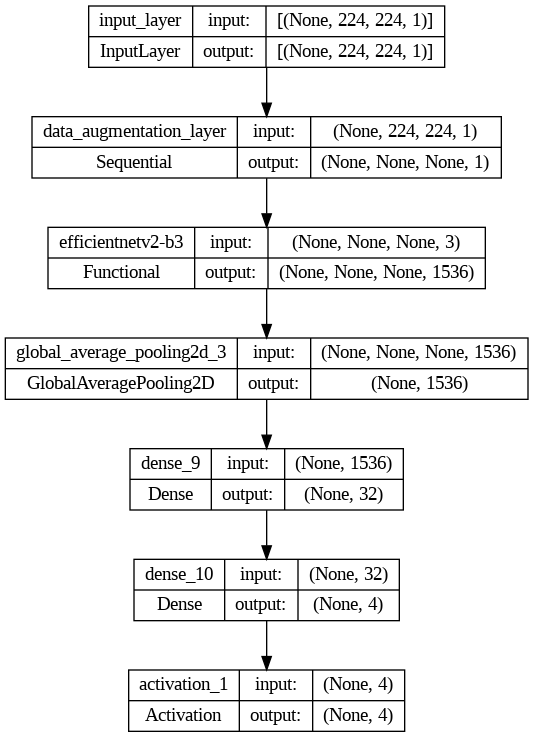

In [42]:
tf.keras.utils.plot_model(efficient_model, show_shapes=True)

In [43]:
efficient_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [44]:
efficient_history = efficient_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
239/239 [==============================] - 51s 160ms/step - loss: 0.6972 - accuracy: 0.7076 - val_loss: 0.7910 - val_accuracy: 0.6699 - lr: 0.0010
Epoch 2/20
239/239 [==============================] - 34s 144ms/step - loss: 0.5734 - accuracy: 0.7716 - val_loss: 0.8591 - val_accuracy: 0.6555 - lr: 0.0010
Epoch 3/20
239/239 [==============================] - 32s 135ms/step - loss: 0.5209 - accuracy: 0.7920 - val_loss: 0.7424 - val_accuracy: 0.6890 - lr: 0.0010
Epoch 4/20
239/239 [==============================] - 31s 129ms/step - loss: 0.5078 - accuracy: 0.8025 - val_loss: 0.6984 - val_accuracy: 0.7368 - lr: 0.0010
Epoch 5/20
239/239 [==============================] - 28s 118ms/step - loss: 0.4713 - accuracy: 0.8143 - val_loss: 0.4822 - val_accuracy: 0.8134 - lr: 0.0010
Epoch 6/20
239/239 [==============================] - 27s 114ms/step - loss: 0.4569 - accuracy: 0.8222 - val_loss: 0.5107 - val_accuracy: 0.7895 - lr: 0.0010
Epoch 7/20
239/239 [==============================] 

EfficientNetV2B3 Evaluation

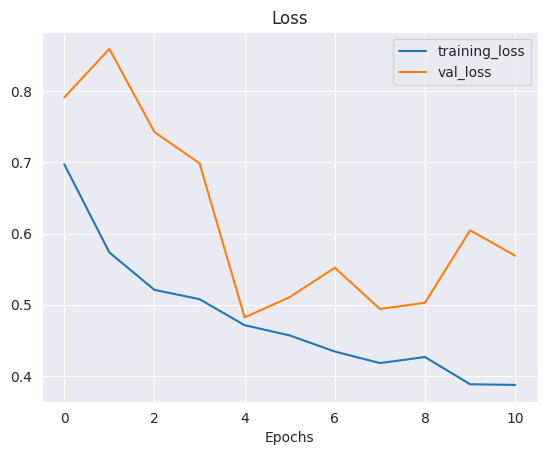

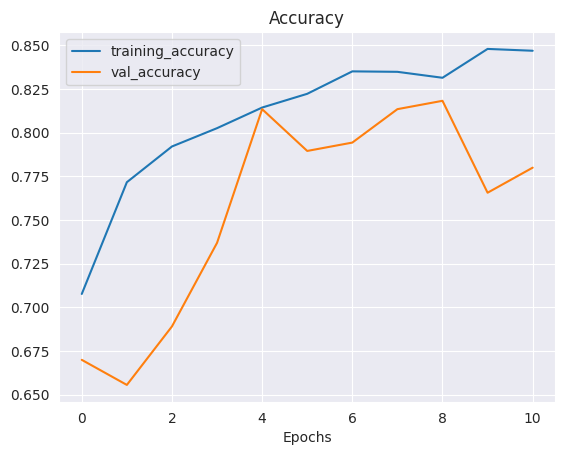

In [45]:
plot_loss_curves(efficient_history)

14/14 [==============================] - 1s 42ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87        53
           1       0.84      0.95      0.89        56
           2       0.90      0.54      0.67        52
           3       0.72      0.87      0.79        55

    accuracy                           0.81       216
   macro avg       0.83      0.81      0.81       216
weighted avg       0.83      0.81      0.81       216

Specificity: [0.2781065088757396, 0.32515337423312884, 0.14893617021276595, 0.2857142857142857]
Mean Squared Error: : 0.1286817491054535
The average AUC-ROC is 0.9536981790944303


[0.9627329192546584,
 0.6535947712418301,
 0.7297297297297297,
 0.6644295302013423,
 0.6521739130434783,
 0.9803921568627451,
 0.6972972972972973,
 0.6442953020134228,
 0.7204968944099379,
 0.6862745098039216,
 0.8702702702702703,
 0.738255033557047,
 0.6645962732919255,
 0.6797385620915033,
 0.7027027027027027,
 0.9530201342281879]

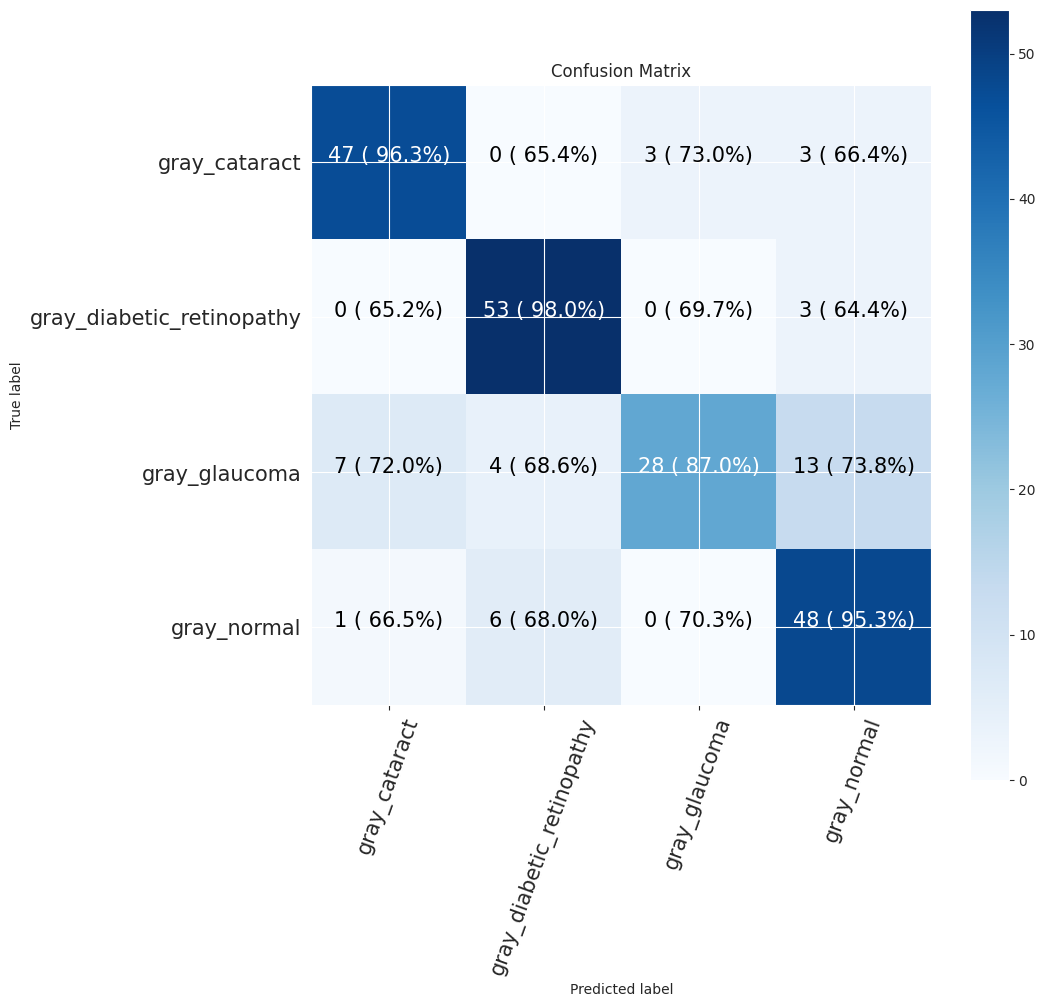

In [47]:
# Save Model
efficient_model.save("efficient_model.h5")

model = efficient_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]

pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels, pred_classes, classes=class_names, figsize=(10, 10))

# make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


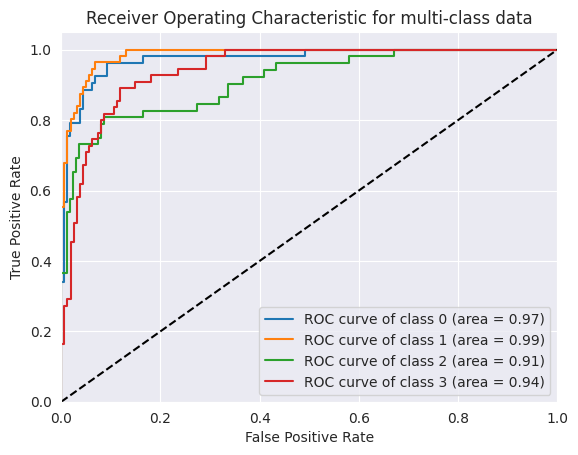

In [48]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **CNN model**

In [49]:

from tensorflow.keras.models import Sequential

# Create a Sequential model
cnn_model = Sequential()

# Add convolutional layers for feature extraction
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))  # Grayscale image has 1 channel

# Freeze the layers in the base model
for layer in cnn_model.layers:
    layer.trainable = False

grayscale_input = layers.Input(shape=(224, 224, 1))

grayscale_input = data_aug(grayscale_input)

cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output for dense layers
cnn_model.add(layers.Flatten())

# Add dense layers for classification
cnn_model.add(layers.Dense(512, activation='relu'))
cnn_model.add(layers.Dense(256, activation='relu'))
cnn_model.add(layers.Dense(4, activation='softmax'))  # Set num_classes to your specific number of classes

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
cnn_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 26, 26, 128)      

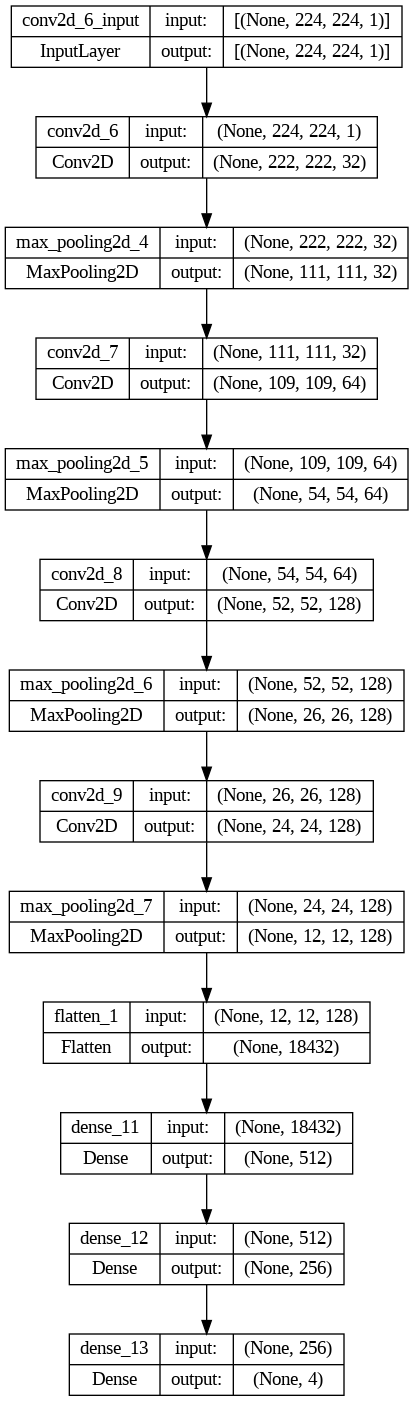

In [50]:
tf.keras.utils.plot_model(cnn_model, show_shapes=True)

In [51]:
cnn_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [52]:
cnn_history = cnn_model.fit(train_data,epochs = epoch, validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
239/239 [==============================] - 7s 22ms/step - loss: 2.7508 - accuracy: 0.5035 - val_loss: 0.9904 - val_accuracy: 0.4976 - lr: 0.0010
Epoch 2/20
239/239 [==============================] - 5s 22ms/step - loss: 0.7980 - accuracy: 0.5993 - val_loss: 0.8378 - val_accuracy: 0.5981 - lr: 0.0010
Epoch 3/20
239/239 [==============================] - 5s 21ms/step - loss: 0.7442 - accuracy: 0.6265 - val_loss: 0.7350 - val_accuracy: 0.6699 - lr: 0.0010
Epoch 4/20
239/239 [==============================] - 5s 21ms/step - loss: 0.6794 - accuracy: 0.6701 - val_loss: 0.7629 - val_accuracy: 0.6316 - lr: 0.0010
Epoch 5/20
239/239 [==============================] - 5s 21ms/step - loss: 0.6670 - accuracy: 0.6892 - val_loss: 0.7403 - val_accuracy: 0.6555 - lr: 0.0010
Epoch 6/20
239/239 [==============================] - 5s 21ms/step - loss: 0.6116 - accuracy: 0.7238 - val_loss: 0.5961 - val_accuracy: 0.7225 - lr: 0.0010
Epoch 7/20
239/239 [==============================] - 5s 21ms/st

CNN Evaluation

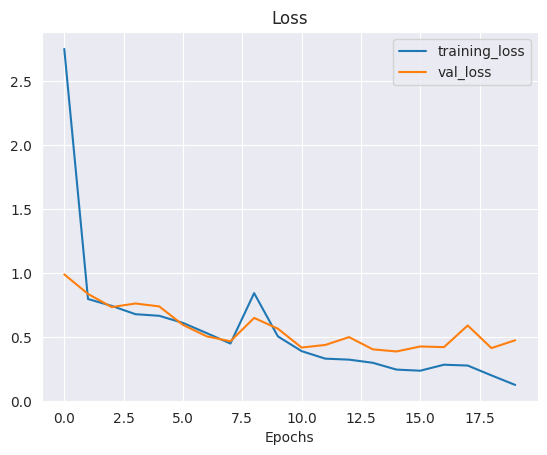

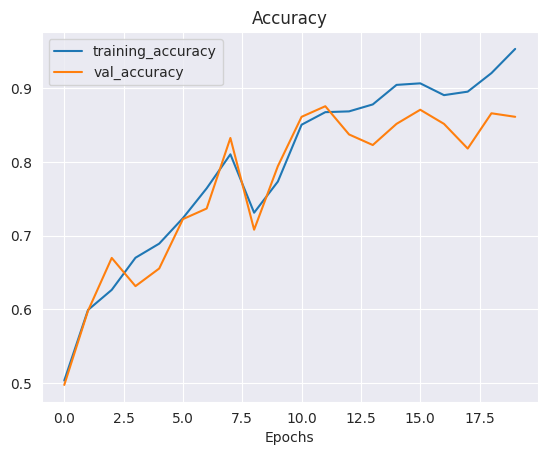

In [53]:
plot_loss_curves(cnn_history)

14/14 [==============================] - 0s 9ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84        53
           1       0.95      1.00      0.97        56
           2       0.82      0.71      0.76        52
           3       0.83      0.91      0.87        55

    accuracy                           0.87       216
   macro avg       0.86      0.86      0.86       216
weighted avg       0.86      0.87      0.86       216

Specificity: [0.2558139534883721, 0.35, 0.20670391061452514, 0.30120481927710846]
Mean Squared Error: : 0.11480667442083359
The average AUC-ROC is 0.9635057319934729


[0.9451219512195121,
 0.6624203821656051,
 0.7251461988304093,
 0.6794871794871795,
 0.6585365853658537,
 1.0,
 0.672514619883041,
 0.6410256410256411,
 0.7134146341463414,
 0.6878980891719745,
 0.9122807017543859,
 0.7115384615384616,
 0.6829268292682927,
 0.6496815286624203,
 0.6900584795321637,
 0.967948717948718]

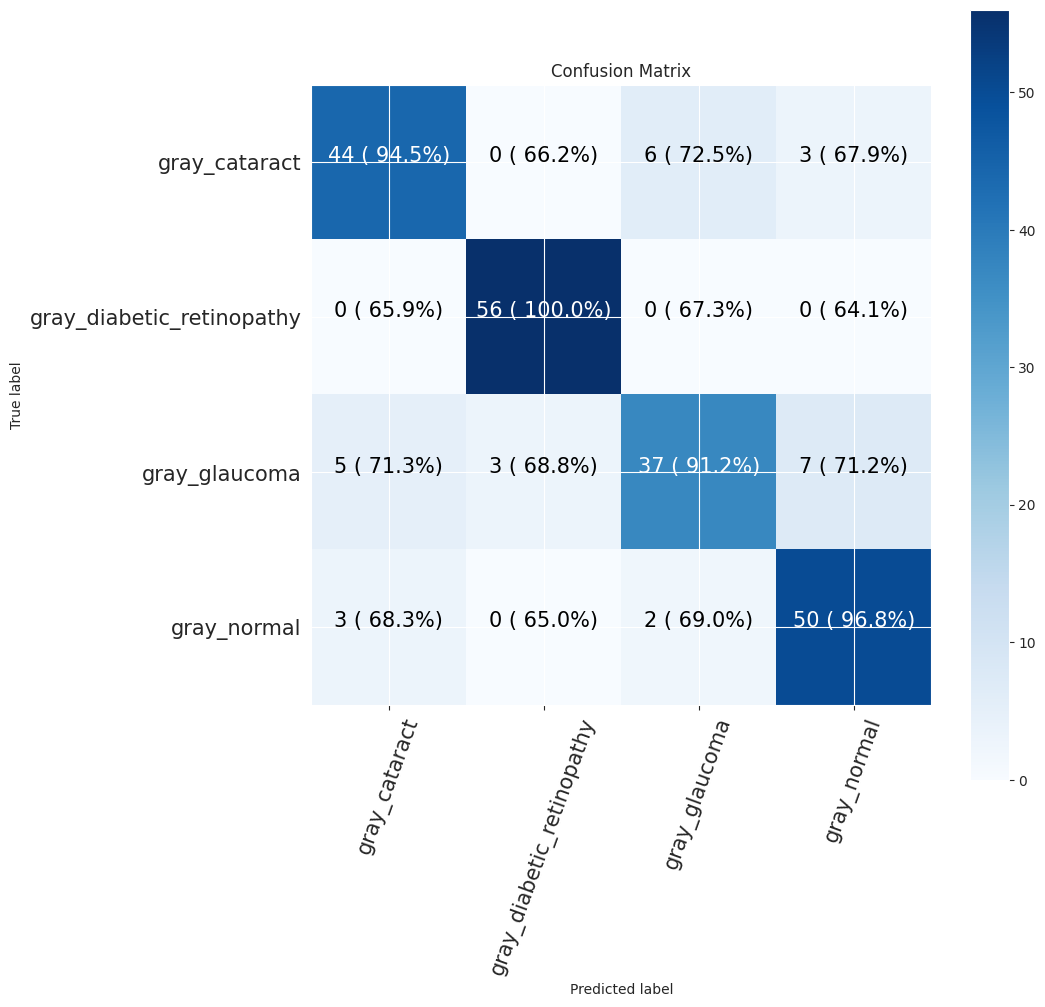

In [55]:
# Save Model
cnn_model.save("cnn_model.h5")

model = cnn_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


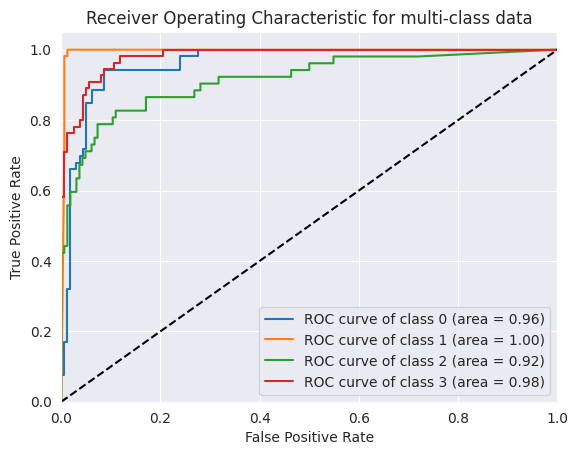

In [56]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet50 Model**



In [62]:
from tensorflow.keras.applications import ResNet50

# Load ResNet-50 without the top classification layers (include_top=False)
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet50_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))

# grayscale_input = Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)
# Convert grayscale to 3 channels (matching the input requirement of ResNet-50)
conv_layer = Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-50 model
x = resnet50_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = layers.Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-50 model for grayscale images
resnet50_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet50_model.summary()


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, None, None, 1)]   0         
                                                                 
 conv2d_11 (Conv2D)          (None, None, None, 3)     30        
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_5  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_16 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_17 (Dense)            (None, 4)                 4100      
                                                           

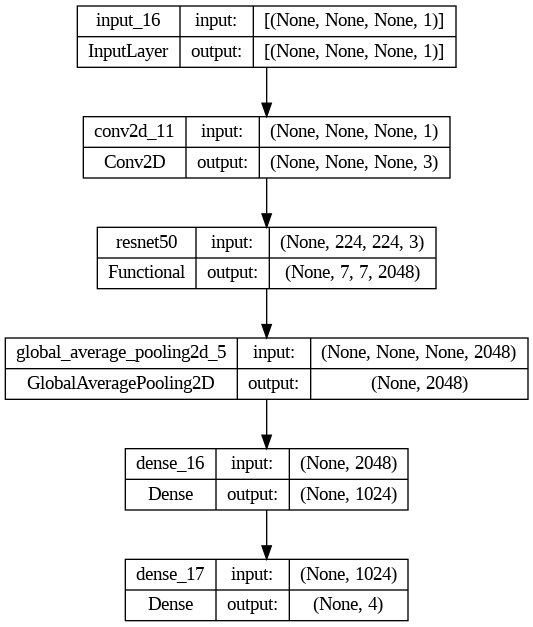

In [63]:
tf.keras.utils.plot_model(resnet50_model, show_shapes=True)

In [64]:
resnet50_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [65]:
resnet50_history = resnet50_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
239/239 [==============================] - 38s 138ms/step - loss: 0.6599 - accuracy: 0.7648 - val_loss: 0.4311 - val_accuracy: 0.8230 - lr: 0.0010
Epoch 2/20
239/239 [==============================] - 32s 133ms/step - loss: 0.3685 - accuracy: 0.8563 - val_loss: 0.3273 - val_accuracy: 0.8517 - lr: 0.0010
Epoch 3/20
239/239 [==============================] - 32s 133ms/step - loss: 0.3142 - accuracy: 0.8820 - val_loss: 0.3399 - val_accuracy: 0.8517 - lr: 0.0010
Epoch 4/20
239/239 [==============================] - 32s 133ms/step - loss: 0.2612 - accuracy: 0.8996 - val_loss: 0.2767 - val_accuracy: 0.8708 - lr: 0.0010
Epoch 5/20
239/239 [==============================] - 32s 133ms/step - loss: 0.2318 - accuracy: 0.9108 - val_loss: 0.4456 - val_accuracy: 0.8182 - lr: 0.0010
Epoch 6/20
239/239 [==============================] - 32s 133ms/step - loss: 0.2152 - accuracy: 0.9124 - val_loss: 0.3682 - val_accuracy: 0.8612 - lr: 0.0010
Epoch 7/20
239/239 [==============================] 

ResNet50 Evaluation

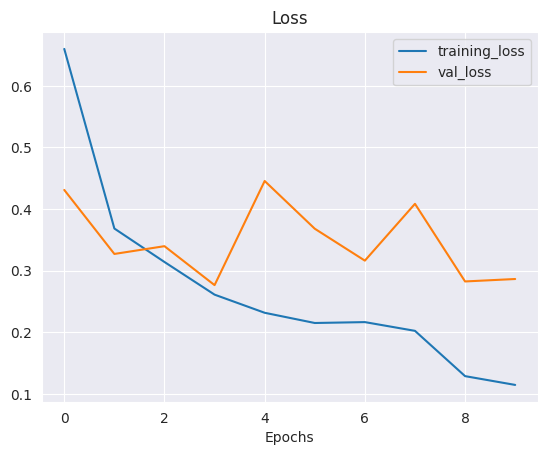

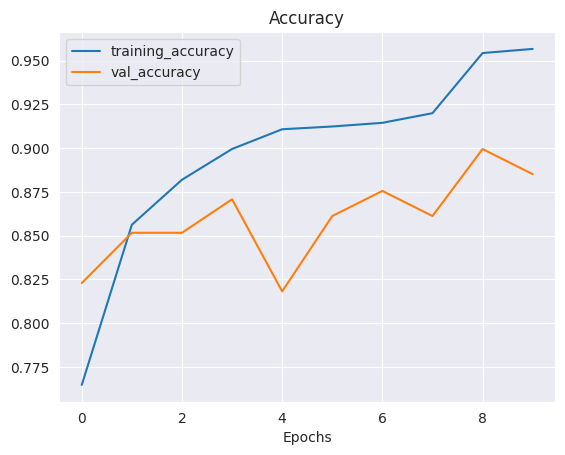

In [66]:
plot_loss_curves(resnet50_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 1s 47ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.91        53
           1       1.00      1.00      1.00        56
           2       0.81      0.90      0.85        52
           3       0.92      0.84      0.88        55

    accuracy                           0.91       216
   macro avg       0.91      0.91      0.91       216
weighted avg       0.92      0.91      0.91       216

Specificity: [0.2857142857142857, 0.35, 0.2781065088757396, 0.27058823529411763]
Mean Squared Error: : 0.10766222327947617
The average AUC-ROC is 0.989928324530319


[0.9695121951219512,
 0.66875,
 0.6835443037974683,
 0.6927710843373494,
 0.6585365853658537,
 1.0,
 0.6455696202531646,
 0.6626506024096386,
 0.7012195121951219,
 0.675,
 0.9683544303797469,
 0.6987951807228916,
 0.6707317073170732,
 0.65625,
 0.7025316455696202,
 0.9457831325301205]

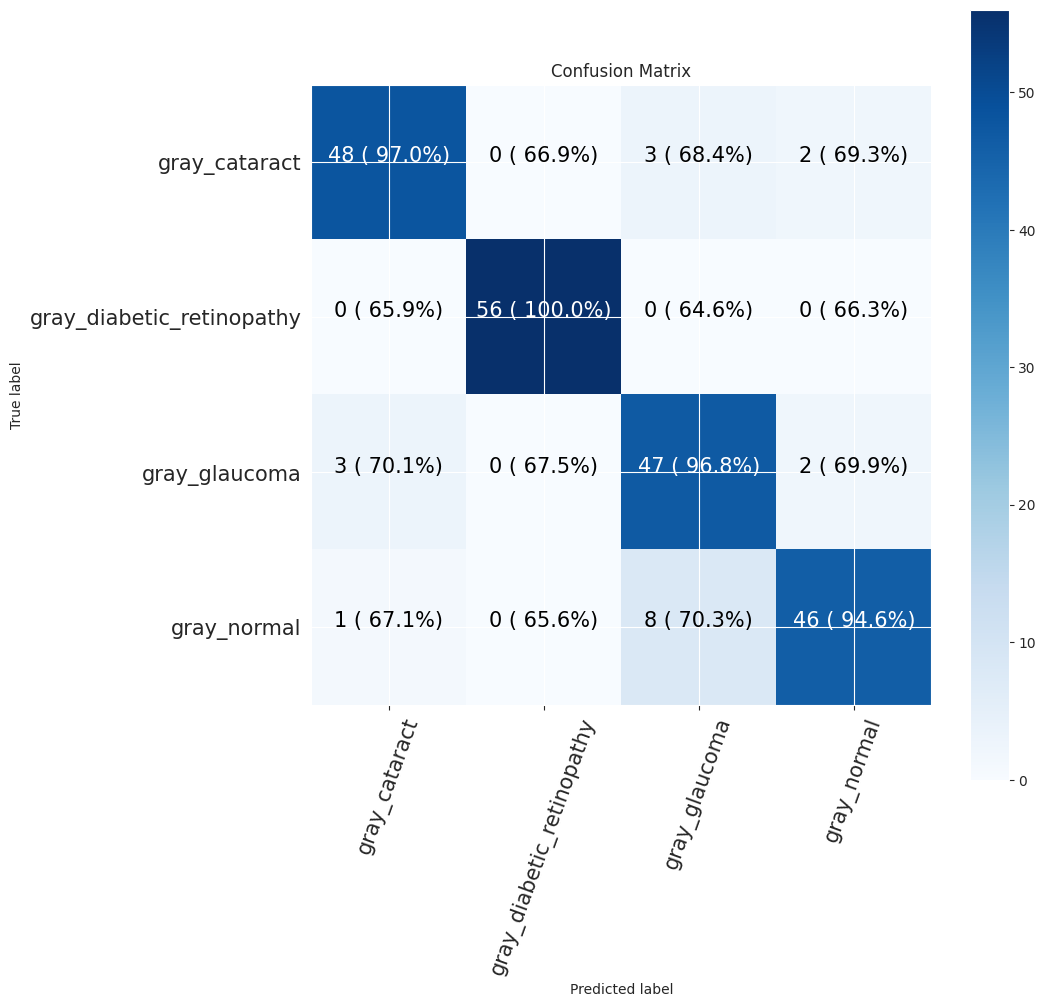

In [67]:
# Save Model
resnet50_model.save("resnet50_model.h5")

model = resnet50_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


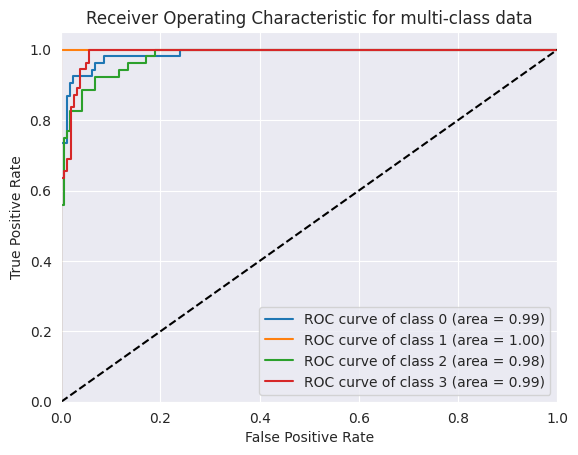

In [68]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet101**

In [69]:
from tensorflow.keras.applications import ResNet101

# Load ResNet-101 without the top classification layers (include_top=False)
resnet101_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet101_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)

# Convert grayscale to 3 channels (matching the input requirement of ResNet-101)
conv_layer = layers.Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-101 model
x = resnet101_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-101 model for grayscale images
resnet101_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet101_model.summary()


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, None, None, 1)]   0         
                                                                 
 conv2d_12 (Conv2D)          (None, None, None, 3)     30        
                                                                 
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d_6  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_18 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_19 (Dense)            (None, 4)                 4100      
                                                           

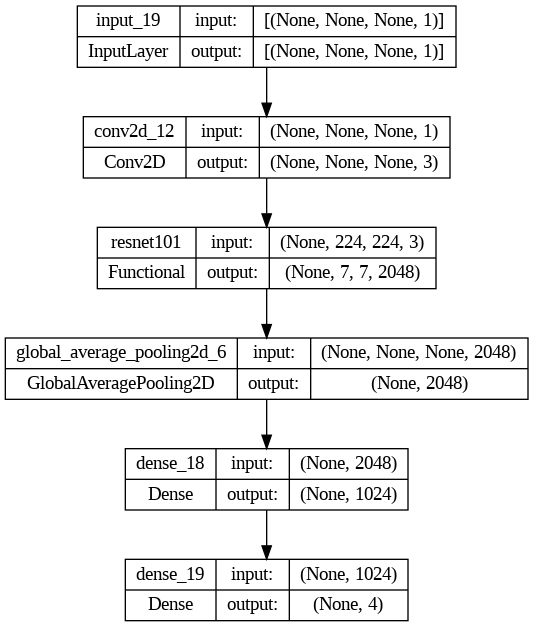

In [70]:
tf.keras.utils.plot_model(resnet101_model, show_shapes=True)

In [71]:
resnet101_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [72]:
resnet101_history= resnet101_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
239/239 [==============================] - 62s 229ms/step - loss: 0.6442 - accuracy: 0.7731 - val_loss: 0.5003 - val_accuracy: 0.8230 - lr: 0.0010
Epoch 2/20
239/239 [==============================] - 52s 217ms/step - loss: 0.3753 - accuracy: 0.8568 - val_loss: 0.3687 - val_accuracy: 0.8373 - lr: 0.0010
Epoch 3/20
239/239 [==============================] - 52s 218ms/step - loss: 0.3321 - accuracy: 0.8720 - val_loss: 0.4168 - val_accuracy: 0.8373 - lr: 0.0010
Epoch 4/20
239/239 [==============================] - 52s 218ms/step - loss: 0.3093 - accuracy: 0.8817 - val_loss: 0.3436 - val_accuracy: 0.8660 - lr: 0.0010
Epoch 5/20
239/239 [==============================] - 52s 218ms/step - loss: 0.2623 - accuracy: 0.9009 - val_loss: 0.3164 - val_accuracy: 0.8612 - lr: 0.0010
Epoch 6/20
239/239 [==============================] - 52s 218ms/step - loss: 0.2422 - accuracy: 0.9072 - val_loss: 0.2854 - val_accuracy: 0.8708 - lr: 0.0010
Epoch 7/20
239/239 [==============================] 

ResNet101 Evaluation

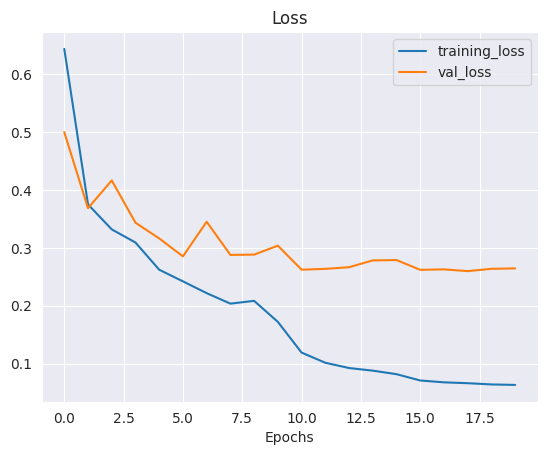

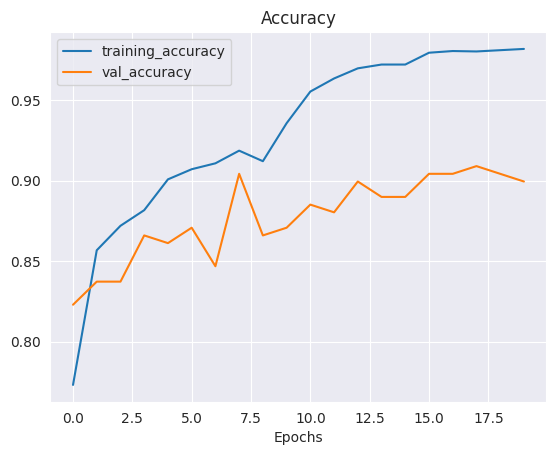

In [73]:
plot_loss_curves(resnet101_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 1s 83ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.92        53
           1       0.98      1.00      0.99        56
           2       0.93      0.79      0.85        52
           3       0.88      0.95      0.91        55

    accuracy                           0.92       216
   macro avg       0.92      0.92      0.92       216
weighted avg       0.92      0.92      0.92       216

Specificity: [0.30120481927710846, 0.35, 0.2342857142857143, 0.3170731707317073]
Mean Squared Error: : 0.1061510369181633
The average AUC-ROC is 0.985447497371682


[0.98125,
 0.6666666666666666,
 0.7034883720930233,
 0.6687898089171974,
 0.65,
 1.0,
 0.6744186046511628,
 0.643312101910828,
 0.7,
 0.6792452830188679,
 0.936046511627907,
 0.7070063694267515,
 0.66875,
 0.6540880503144654,
 0.686046511627907,
 0.9808917197452229]

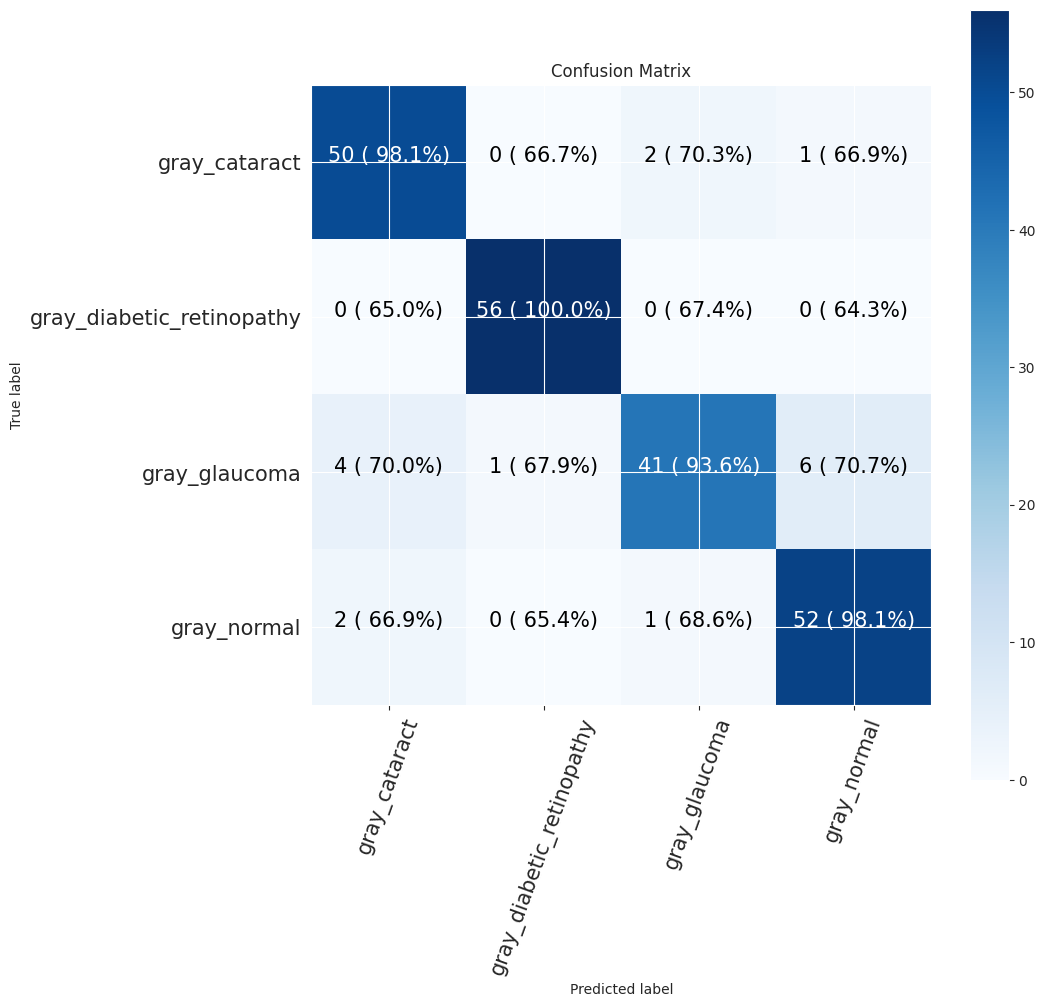

In [74]:
# Save Model
resnet101_model.save("resnet101_model.h5")

model = resnet101_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


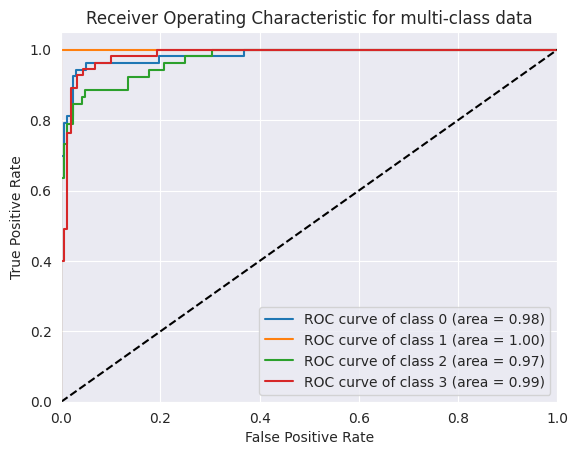

In [75]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **Batch size: 32**

In [76]:
epoch = 20
batchsize = 32

In [77]:
train_dir = "outputgrayscale/train"
test_dir =  "outputgrayscale/test"
val_dir = "outputgrayscale/val"

train_classes = sorted([name for name in os.listdir(train_dir)])
class_names = train_classes  # Assuming class names are the same across train, test, and val

# Load datasets
train_data = image_dataset_from_directory(train_dir, label_mode="categorical",
                                          image_size=(224, 224), batch_size=batchsize,
                                          shuffle=True, seed=42, color_mode='grayscale')

test_data = image_dataset_from_directory(test_dir, label_mode="categorical",
                                         image_size=(224, 224), batch_size=batchsize,
                                         shuffle=False, seed=42, color_mode='grayscale')

val_data = image_dataset_from_directory(val_dir, label_mode="categorical",
                                        image_size=(224, 224), batch_size=batchsize,
                                        shuffle=False, seed=42, color_mode='grayscale')


Found 3813 files belonging to 4 classes.
Found 216 files belonging to 4 classes.
Found 209 files belonging to 4 classes.


In [78]:
train_data = train_data.map(lambda x, y: (sharpen_image(x), y))
test_data = test_data.map(lambda x, y: (sharpen_image(x), y))
val_data = val_data.map(lambda x, y: (sharpen_image(x), y))

# **EfficientNetV2B3 Model**

In [79]:
efficient_model = tf.keras.applications.EfficientNetV2B3(include_top = False)
efficient_model.trainable = False


In [80]:
inputs = layers.Input(shape=(224, 224, 1), name="input_layer")
x = data_aug(inputs)
# x = inputs
x = efficient_model(x)

# Apply Global Average Pooling
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(32, activation="relu", kernel_initializer=tf.keras.initializers.he_normal())(x)
x = layers.Dense(4)(x)
outputs = layers.Activation("softmax", dtype=tf.float32)(x)

efficient_model = tf.keras.Model(inputs, outputs)
efficient_model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 1)]     0         
                                                                 
 data_augmentation_layer (S  (None, None, None, 1)     0         
 equential)                                                      
                                                                 
 efficientnetv2-b3 (Functio  (None, None, None, 1536   12930622  
 nal)                        )                                   
                                                                 
 global_average_pooling2d_7  (None, 1536)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_20 (Dense)            (None, 32)                49184     
                                                           

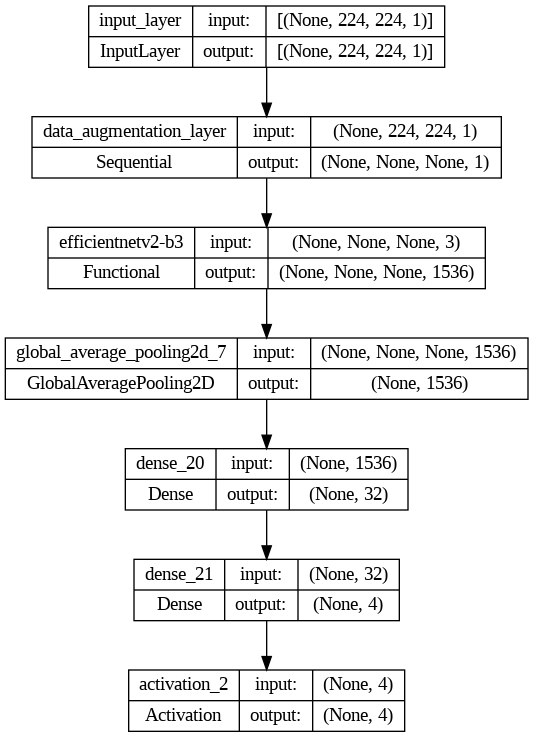

In [81]:
tf.keras.utils.plot_model(efficient_model, show_shapes=True)

In [82]:
efficient_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [83]:
efficient_history = efficient_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
120/120 [==============================] - 116s 860ms/step - loss: 0.7456 - accuracy: 0.6947 - val_loss: 0.7898 - val_accuracy: 0.6699 - lr: 0.0010
Epoch 2/20
120/120 [==============================] - 85s 705ms/step - loss: 0.5451 - accuracy: 0.7836 - val_loss: 0.8394 - val_accuracy: 0.6699 - lr: 0.0010
Epoch 3/20
120/120 [==============================] - 80s 672ms/step - loss: 0.5219 - accuracy: 0.8020 - val_loss: 0.7797 - val_accuracy: 0.6651 - lr: 0.0010
Epoch 4/20
120/120 [==============================] - 72s 595ms/step - loss: 0.5015 - accuracy: 0.8088 - val_loss: 0.8958 - val_accuracy: 0.6172 - lr: 0.0010
Epoch 5/20
120/120 [==============================] - 66s 547ms/step - loss: 0.4760 - accuracy: 0.8130 - val_loss: 0.5493 - val_accuracy: 0.7943 - lr: 0.0010
Epoch 6/20
120/120 [==============================] - 61s 504ms/step - loss: 0.4681 - accuracy: 0.8049 - val_loss: 0.6150 - val_accuracy: 0.7895 - lr: 0.0010
Epoch 7/20
120/120 [==============================]

EfficientNetV2B3 Evaluation

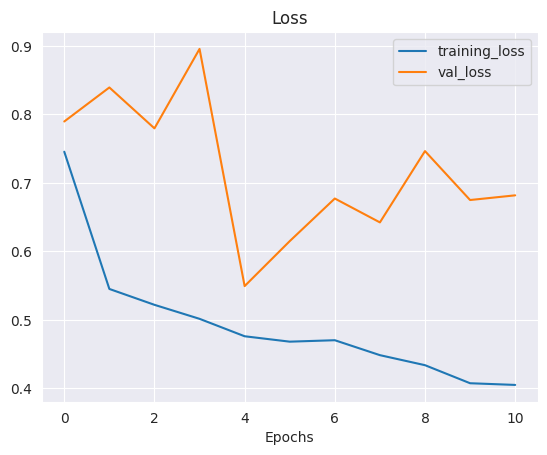

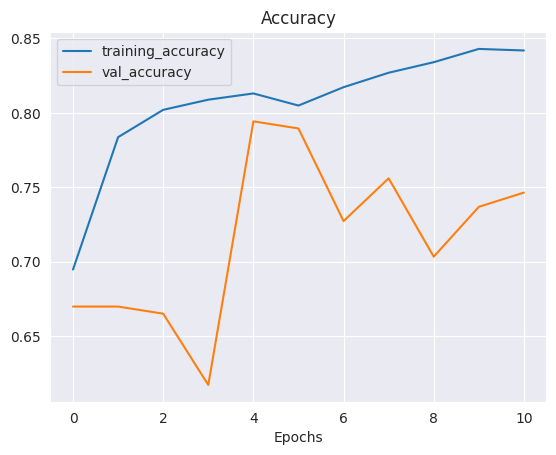

In [84]:
plot_loss_curves(efficient_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 1s 76ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.91      0.87        53
           1       0.83      0.86      0.84        56
           2       0.92      0.42      0.58        52
           3       0.65      0.91      0.76        55

    accuracy                           0.78       216
   macro avg       0.81      0.77      0.76       216
weighted avg       0.81      0.78      0.76       216

Specificity: [0.2857142857142857, 0.2857142857142857, 0.1134020618556701, 0.30120481927710846]
Mean Squared Error: : 0.1327212154865265
The average AUC-ROC is 0.9492390238589798


[0.9685534591194969,
 0.6645569620253164,
 0.734375,
 0.6402877697841727,
 0.6477987421383647,
 0.9493670886075949,
 0.7083333333333334,
 0.6546762589928058,
 0.7232704402515723,
 0.7088607594936709,
 0.84375,
 0.7410071942446043,
 0.660377358490566,
 0.6772151898734177,
 0.7135416666666666,
 0.9640287769784173]

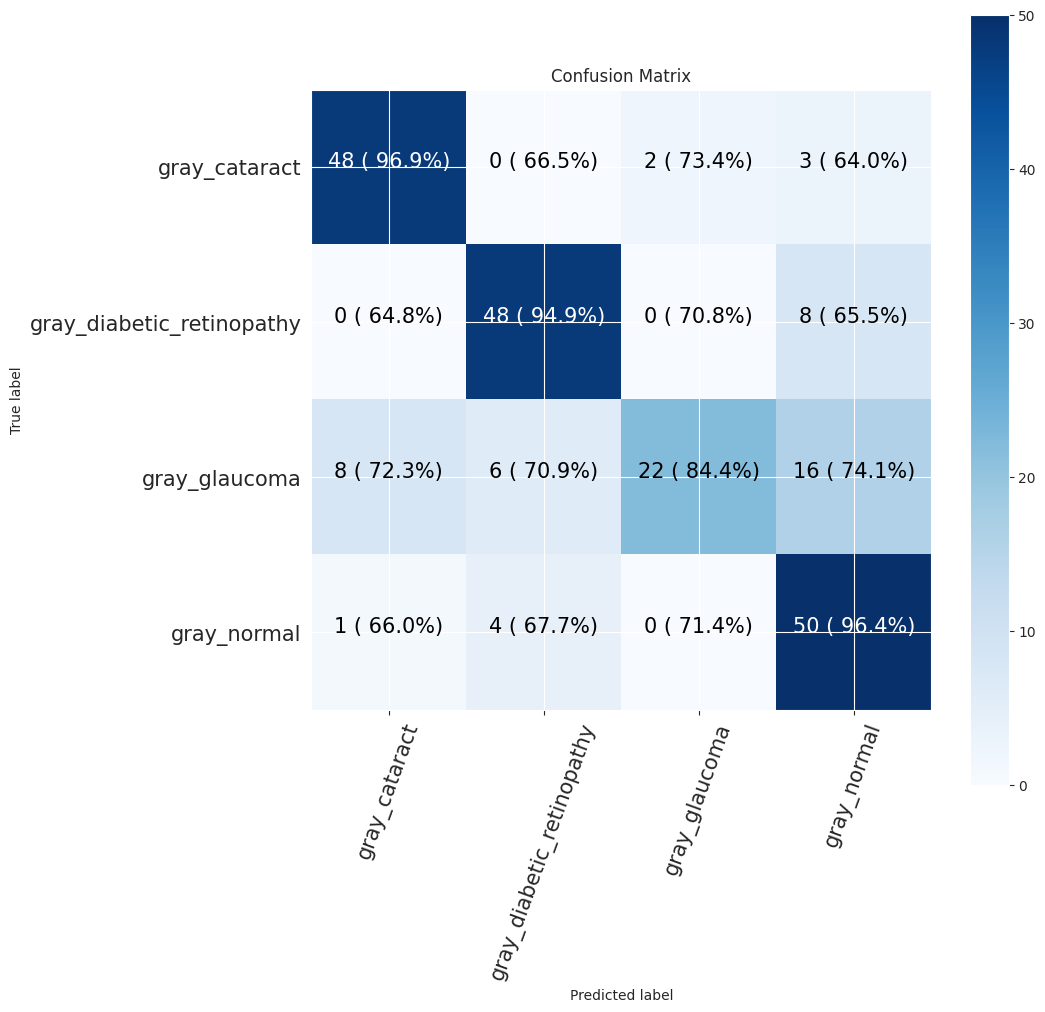

In [85]:
# Save Model
efficient_model.save("efficient_model.h5")

model = efficient_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


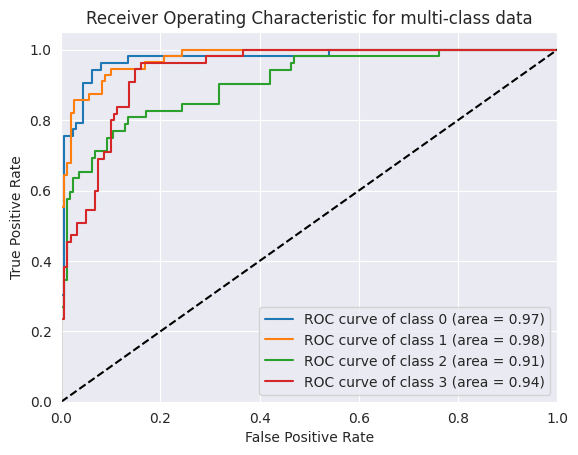

In [86]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **CNN model**

In [87]:
from tensorflow.keras.models import Sequential

# Create a Sequential model
cnn_model = Sequential()

# Add convolutional layers for feature extraction
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))  # Grayscale image has 1 channel

# Freeze the layers in the base model
for layer in cnn_model.layers:
    layer.trainable = False

grayscale_input = layers.Input(shape=(224, 224, 1))

grayscale_input = data_aug(grayscale_input)

cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output for dense layers
cnn_model.add(layers.Flatten())

# Add dense layers for classification
cnn_model.add(layers.Dense(512, activation='relu'))
cnn_model.add(layers.Dense(256, activation='relu'))
cnn_model.add(layers.Dense(4, activation='softmax'))  # Set num_classes to your specific number of classes

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
cnn_model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 26, 26, 128)      

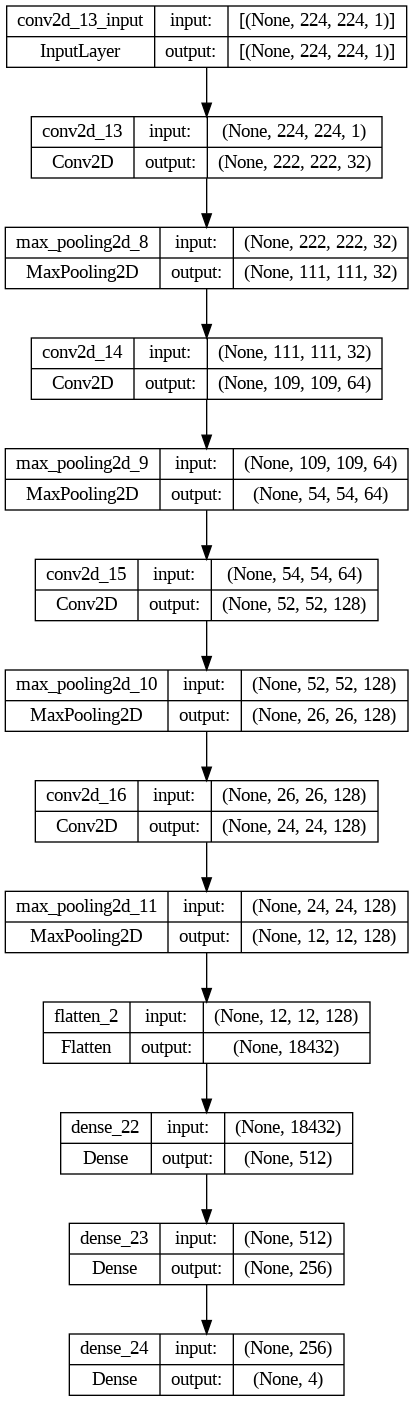

In [88]:
tf.keras.utils.plot_model(cnn_model, show_shapes=True)

In [89]:
cnn_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [90]:
cnn_history = cnn_model.fit(train_data,epochs = epoch, validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
120/120 [==============================] - 8s 39ms/step - loss: 4.0189 - accuracy: 0.5481 - val_loss: 0.7160 - val_accuracy: 0.6890 - lr: 0.0010
Epoch 2/20
120/120 [==============================] - 4s 35ms/step - loss: 0.8548 - accuracy: 0.6483 - val_loss: 0.9604 - val_accuracy: 0.5359 - lr: 0.0010
Epoch 3/20
120/120 [==============================] - 4s 34ms/step - loss: 0.8153 - accuracy: 0.6174 - val_loss: 0.7729 - val_accuracy: 0.6364 - lr: 0.0010
Epoch 4/20
120/120 [==============================] - 4s 34ms/step - loss: 0.7664 - accuracy: 0.6499 - val_loss: 0.6976 - val_accuracy: 0.6555 - lr: 0.0010
Epoch 5/20
120/120 [==============================] - 4s 34ms/step - loss: 0.6435 - accuracy: 0.6997 - val_loss: 0.6780 - val_accuracy: 0.7033 - lr: 0.0010
Epoch 6/20
120/120 [==============================] - 4s 35ms/step - loss: 0.6134 - accuracy: 0.7139 - val_loss: 0.6332 - val_accuracy: 0.6986 - lr: 0.0010
Epoch 7/20
120/120 [==============================] - 4s 34ms/st

CNN Evaluation

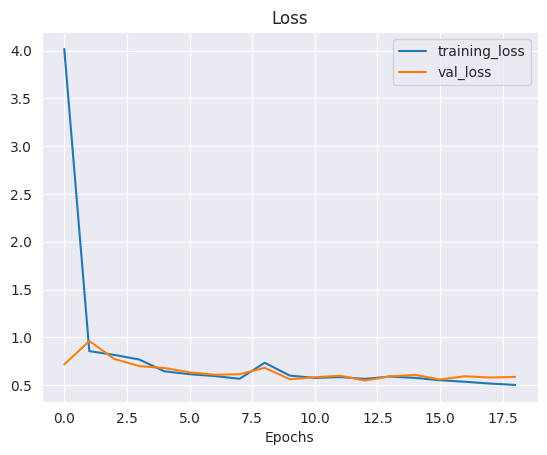

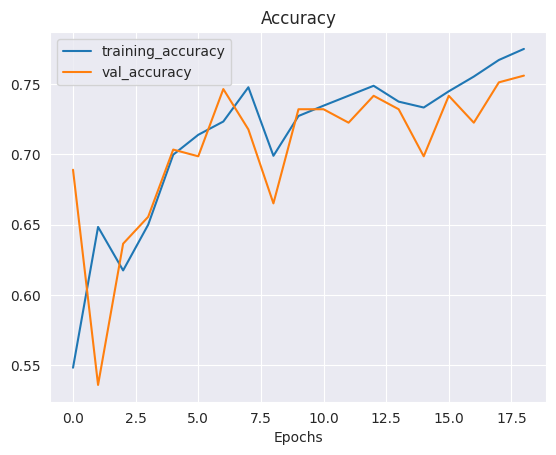

In [91]:
plot_loss_curves(cnn_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 0s 13ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.60      0.65        53
           1       1.00      1.00      1.00        56
           2       0.62      0.46      0.53        52
           3       0.70      0.96      0.81        55

    accuracy                           0.76       216
   macro avg       0.76      0.76      0.75       216
weighted avg       0.76      0.76      0.75       216

Specificity: [0.17391304347826086, 0.35, 0.125, 0.32515337423312884]
Mean Squared Error: : 0.1347845196723938
The average AUC-ROC is 0.9228808597519492


[0.8771929824561403,
 0.66875,
 0.7740112994350282,
 0.6785714285714286,
 0.672514619883041,
 1.0,
 0.6836158192090396,
 0.6,
 0.7719298245614035,
 0.675,
 0.8418079096045198,
 0.7357142857142858,
 0.6783625730994152,
 0.65625,
 0.7005649717514124,
 0.9857142857142858]

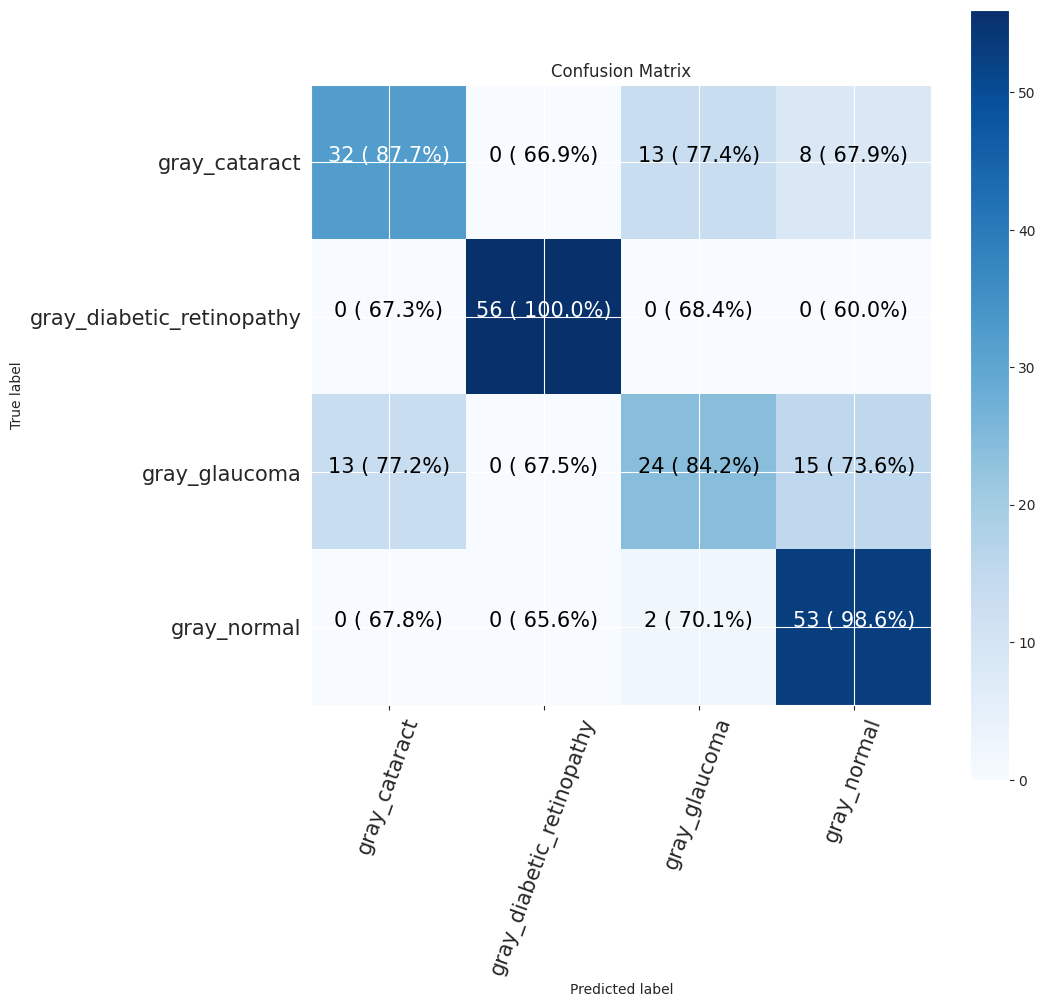

In [92]:
# Save Model
cnn_model.save("cnn_model.h5")

model = cnn_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


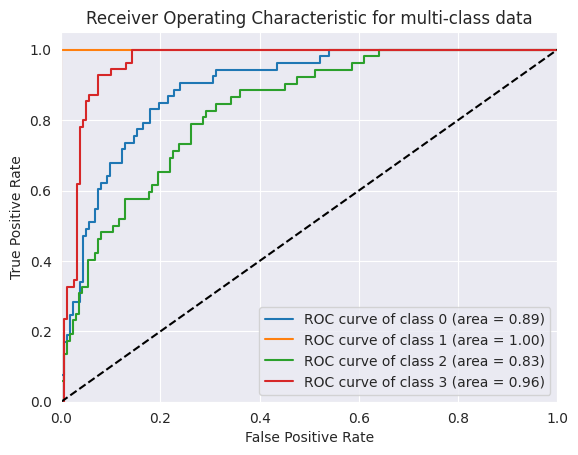

In [93]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet50 Model**



In [94]:
from tensorflow.keras.applications import ResNet50

# Load ResNet-50 without the top classification layers (include_top=False)
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet50_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))

# grayscale_input = Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)
# Convert grayscale to 3 channels (matching the input requirement of ResNet-50)
conv_layer = Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-50 model
x = resnet50_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = layers.Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-50 model for grayscale images
resnet50_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet50_model.summary()


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, None, None, 1)]   0         
                                                                 
 conv2d_17 (Conv2D)          (None, None, None, 3)     30        
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_8  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_25 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_26 (Dense)            (None, 4)                 4100      
                                                           

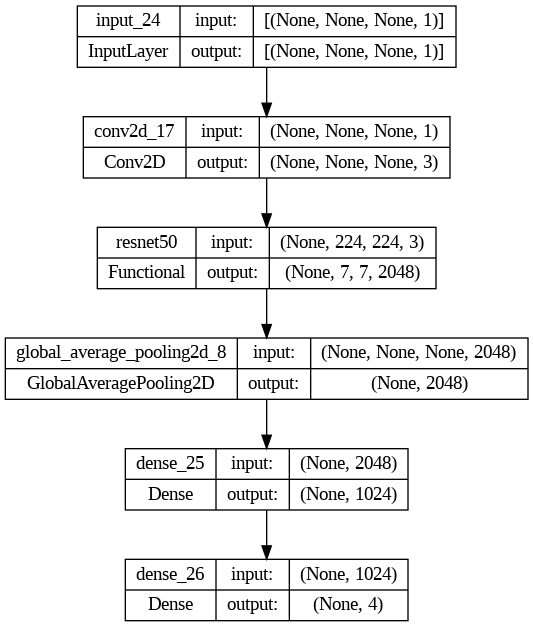

In [95]:
tf.keras.utils.plot_model(resnet50_model, show_shapes=True)

In [96]:
resnet50_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [97]:
resnet50_history = resnet50_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
120/120 [==============================] - 41s 276ms/step - loss: 0.7083 - accuracy: 0.7574 - val_loss: 0.5610 - val_accuracy: 0.8038 - lr: 0.0010
Epoch 2/20
120/120 [==============================] - 30s 251ms/step - loss: 0.3721 - accuracy: 0.8571 - val_loss: 0.3456 - val_accuracy: 0.8708 - lr: 0.0010
Epoch 3/20
120/120 [==============================] - 30s 251ms/step - loss: 0.2918 - accuracy: 0.8880 - val_loss: 0.3808 - val_accuracy: 0.8469 - lr: 0.0010
Epoch 4/20
120/120 [==============================] - 30s 252ms/step - loss: 0.2801 - accuracy: 0.8925 - val_loss: 0.3157 - val_accuracy: 0.8804 - lr: 0.0010
Epoch 5/20
120/120 [==============================] - 30s 251ms/step - loss: 0.2232 - accuracy: 0.9132 - val_loss: 0.2713 - val_accuracy: 0.8852 - lr: 0.0010
Epoch 6/20
120/120 [==============================] - 30s 251ms/step - loss: 0.1912 - accuracy: 0.9229 - val_loss: 0.2826 - val_accuracy: 0.8852 - lr: 0.0010
Epoch 7/20
120/120 [==============================] 

ResNet50 Evaluation

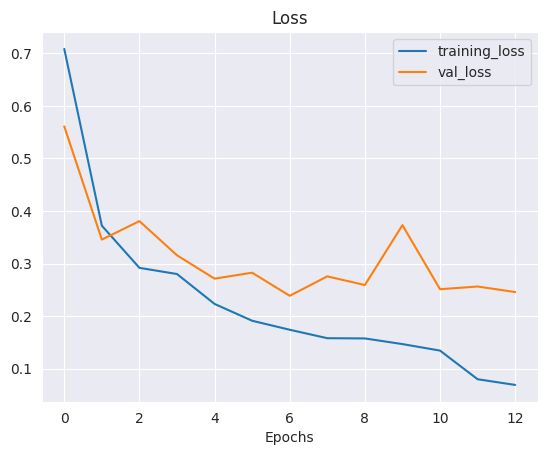

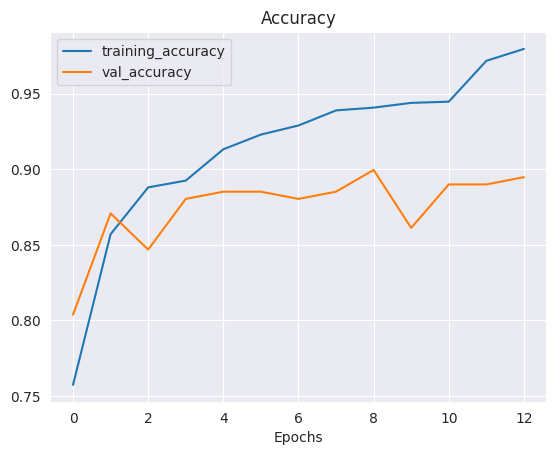

In [98]:
plot_loss_curves(resnet50_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 1s 90ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90        53
           1       1.00      1.00      1.00        56
           2       0.82      0.81      0.82        52
           3       0.89      0.85      0.87        55

    accuracy                           0.90       216
   macro avg       0.90      0.90      0.90       216
weighted avg       0.90      0.90      0.90       216

Specificity: [0.2934131736526946, 0.35, 0.2413793103448276, 0.2781065088757396]
Mean Squared Error: : 0.1074446365237236
The average AUC-ROC is 0.9866881880988987


[0.975,
 0.66875,
 0.696969696969697,
 0.6809815950920245,
 0.65,
 1.0,
 0.6606060606060606,
 0.656441717791411,
 0.70625,
 0.675,
 0.9393939393939394,
 0.7116564417177914,
 0.66875,
 0.65625,
 0.703030303030303,
 0.950920245398773]

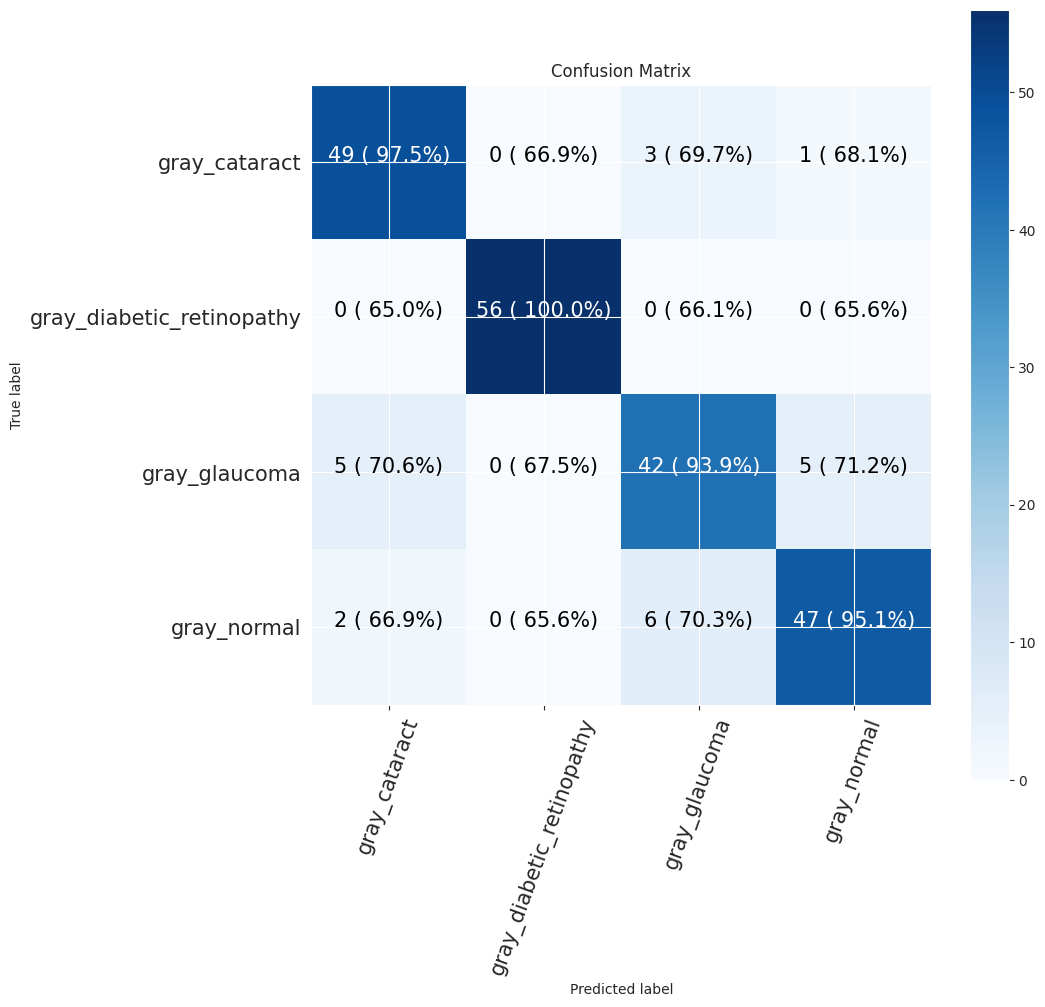

In [99]:
# Save Model
resnet50_model.save("resnet50_model.h5")

model = resnet50_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


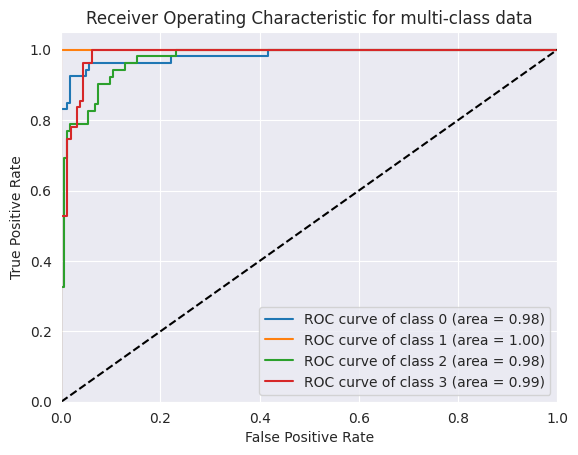

In [100]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet101**

In [101]:
from tensorflow.keras.applications import ResNet101

# Load ResNet-101 without the top classification layers (include_top=False)
resnet101_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet101_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)

# Convert grayscale to 3 channels (matching the input requirement of ResNet-101)
conv_layer = layers.Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-101 model
x = resnet101_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-101 model for grayscale images
resnet101_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet101_model.summary()


Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, None, None, 1)]   0         
                                                                 
 conv2d_18 (Conv2D)          (None, None, None, 3)     30        
                                                                 
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d_9  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_27 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_28 (Dense)            (None, 4)                 4100      
                                                           

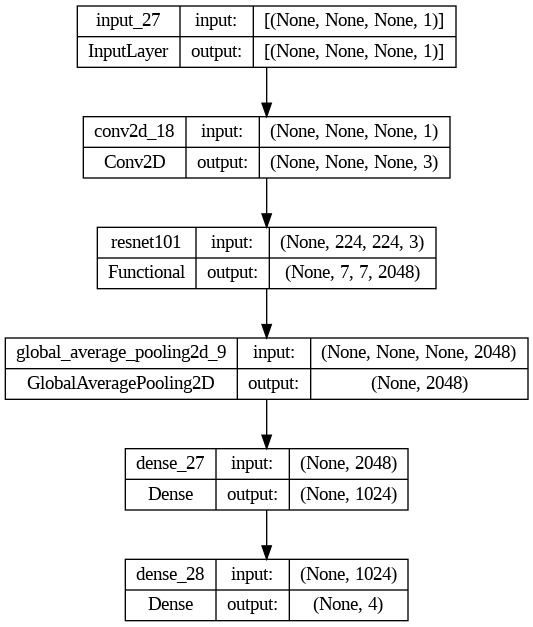

In [102]:
tf.keras.utils.plot_model(resnet101_model, show_shapes=True)

In [103]:
resnet101_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [104]:
resnet101_history= resnet101_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
120/120 [==============================] - 62s 438ms/step - loss: 0.6888 - accuracy: 0.7451 - val_loss: 0.5868 - val_accuracy: 0.7895 - lr: 0.0010
Epoch 2/20
120/120 [==============================] - 50s 413ms/step - loss: 0.3920 - accuracy: 0.8565 - val_loss: 0.4016 - val_accuracy: 0.8565 - lr: 0.0010
Epoch 3/20
120/120 [==============================] - 50s 416ms/step - loss: 0.3426 - accuracy: 0.8678 - val_loss: 0.4081 - val_accuracy: 0.8421 - lr: 0.0010
Epoch 4/20
120/120 [==============================] - 50s 414ms/step - loss: 0.3092 - accuracy: 0.8830 - val_loss: 0.3520 - val_accuracy: 0.8565 - lr: 0.0010
Epoch 5/20
120/120 [==============================] - 50s 414ms/step - loss: 0.2719 - accuracy: 0.8972 - val_loss: 0.3499 - val_accuracy: 0.8517 - lr: 0.0010
Epoch 6/20
120/120 [==============================] - 50s 415ms/step - loss: 0.2473 - accuracy: 0.9058 - val_loss: 0.3252 - val_accuracy: 0.8517 - lr: 0.0010
Epoch 7/20
120/120 [==============================] 

ResNet101 Evaluation

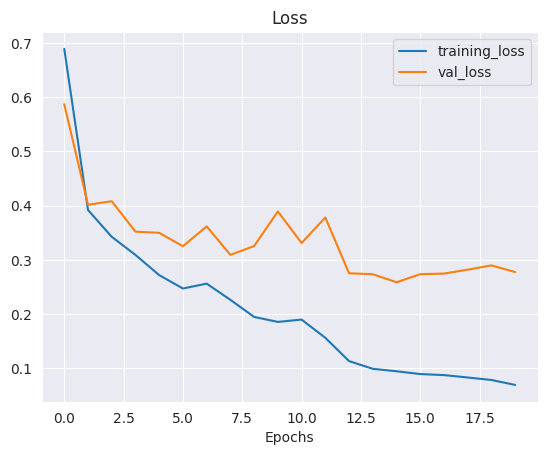

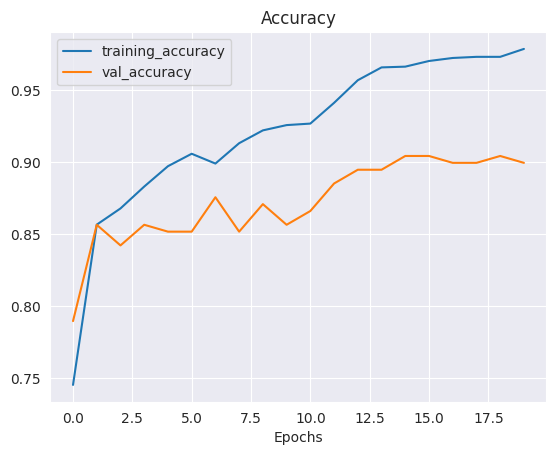

In [105]:
plot_loss_curves(resnet101_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 1s 156ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.94      0.90        53
           1       1.00      0.98      0.99        56
           2       0.95      0.81      0.88        52
           3       0.92      0.98      0.95        55

    accuracy                           0.93       216
   macro avg       0.93      0.93      0.93       216
weighted avg       0.93      0.93      0.93       216

Specificity: [0.30120481927710846, 0.3416149068322981, 0.2413793103448276, 0.3333333333333333]
Mean Squared Error: : 0.10628906637430191
The average AUC-ROC is 0.9873766444131428


[0.9810126582278481,
 0.6708074534161491,
 0.7034883720930233,
 0.6687898089171974,
 0.6455696202531646,
 0.9937888198757764,
 0.6744186046511628,
 0.6496815286624203,
 0.7151898734177216,
 0.6770186335403726,
 0.9418604651162791,
 0.6878980891719745,
 0.6582278481012658,
 0.6583850931677019,
 0.6802325581395349,
 0.9936305732484076]

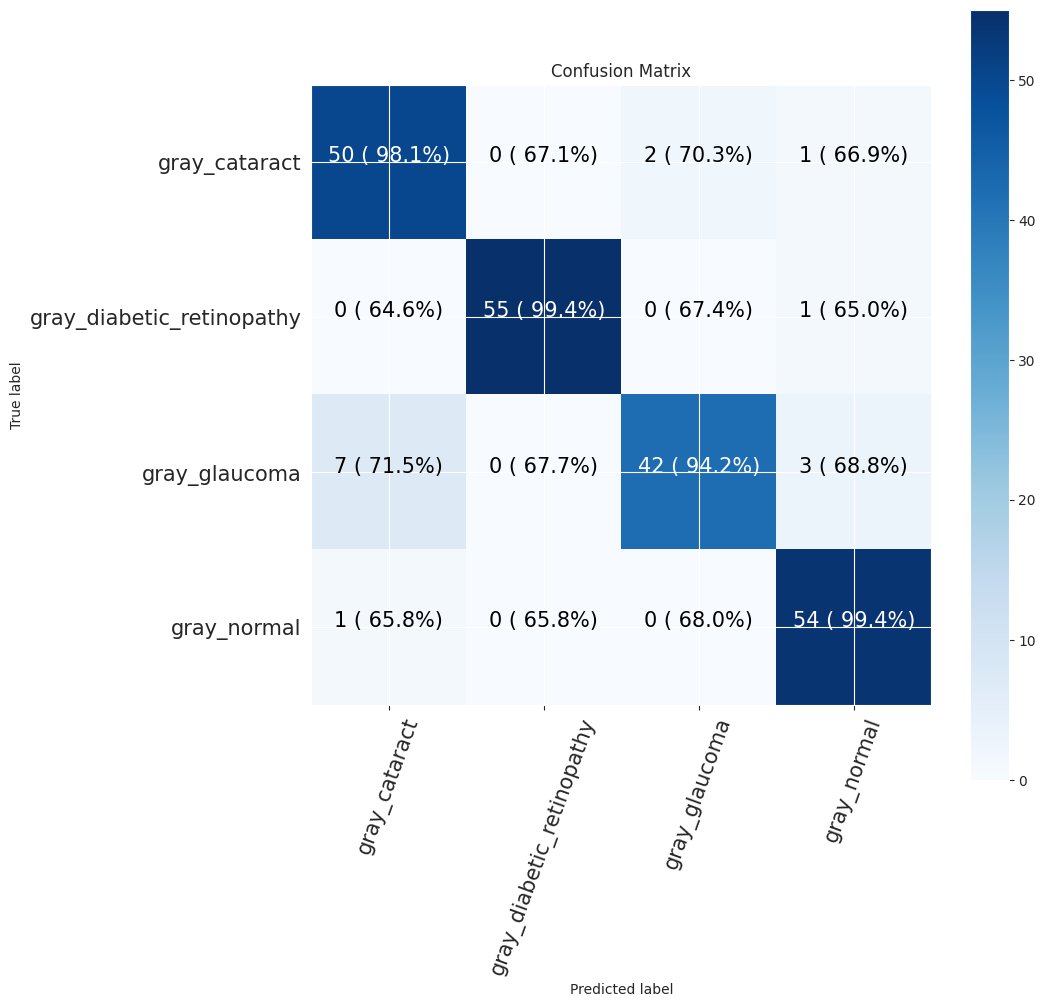

In [106]:
# Save Model
resnet101_model.save("resnet101_model.h5")

model = resnet101_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


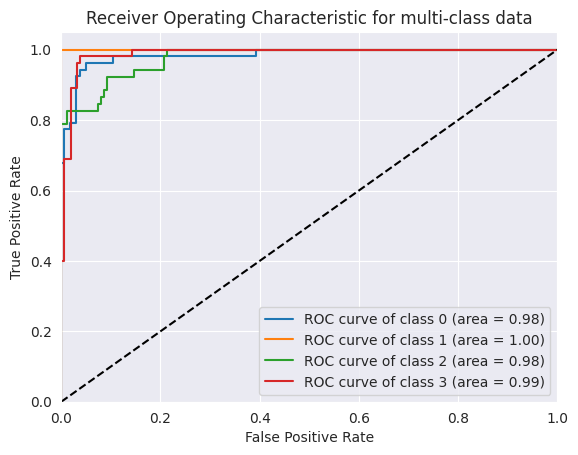

In [107]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **Batch size: 64**

In [108]:
epoch = 20
batchsize = 64

In [109]:
train_dir = "outputgrayscale/train"
test_dir =  "outputgrayscale/test"
val_dir = "outputgrayscale/val"

train_classes = sorted([name for name in os.listdir(train_dir)])
class_names = train_classes  # Assuming class names are the same across train, test, and val

# Load datasets
train_data = image_dataset_from_directory(train_dir, label_mode="categorical",
                                          image_size=(224, 224), batch_size=batchsize,
                                          shuffle=True, seed=42, color_mode='grayscale')

test_data = image_dataset_from_directory(test_dir, label_mode="categorical",
                                         image_size=(224, 224), batch_size=batchsize,
                                         shuffle=False, seed=42, color_mode='grayscale')

val_data = image_dataset_from_directory(val_dir, label_mode="categorical",
                                        image_size=(224, 224), batch_size=batchsize,
                                        shuffle=False, seed=42, color_mode='grayscale')


Found 3813 files belonging to 4 classes.
Found 216 files belonging to 4 classes.
Found 209 files belonging to 4 classes.


In [110]:
train_data = train_data.map(lambda x, y: (sharpen_image(x), y))
test_data = test_data.map(lambda x, y: (sharpen_image(x), y))
val_data = val_data.map(lambda x, y: (sharpen_image(x), y))

# **EfficientNetV2B3 Model**

In [111]:
efficient_model = tf.keras.applications.EfficientNetV2B3(include_top = False)
efficient_model.trainable = False


In [112]:
inputs = layers.Input(shape=(224, 224, 1), name="input_layer")
x = data_aug(inputs)
# x = inputs
x = efficient_model(x)

# Apply Global Average Pooling
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(32, activation="relu", kernel_initializer=tf.keras.initializers.he_normal())(x)
x = layers.Dense(4)(x)
outputs = layers.Activation("softmax", dtype=tf.float32)(x)

efficient_model = tf.keras.Model(inputs, outputs)
efficient_model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 1)]     0         
                                                                 
 data_augmentation_layer (S  (None, None, None, 1)     0         
 equential)                                                      
                                                                 
 efficientnetv2-b3 (Functio  (None, None, None, 1536   12930622  
 nal)                        )                                   
                                                                 
 global_average_pooling2d_1  (None, 1536)              0         
 0 (GlobalAveragePooling2D)                                      
                                                                 
 dense_29 (Dense)            (None, 32)                49184     
                                                          

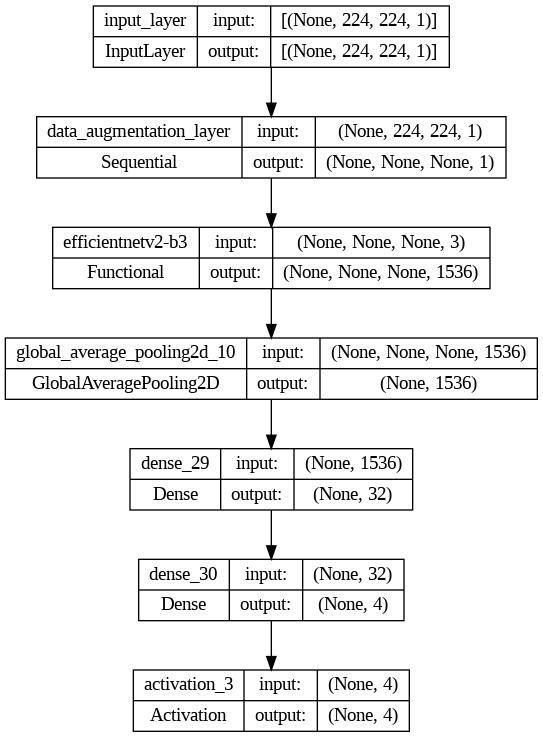

In [113]:
tf.keras.utils.plot_model(efficient_model, show_shapes=True)

In [114]:
efficient_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [115]:
efficient_history = efficient_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
60/60 [==============================] - 113s 2s/step - loss: 0.8337 - accuracy: 0.6499 - val_loss: 0.7571 - val_accuracy: 0.6699 - lr: 0.0010
Epoch 2/20
60/60 [==============================] - 88s 1s/step - loss: 0.5934 - accuracy: 0.7621 - val_loss: 0.7930 - val_accuracy: 0.6172 - lr: 0.0010
Epoch 3/20
60/60 [==============================] - 82s 1s/step - loss: 0.5636 - accuracy: 0.7831 - val_loss: 0.6663 - val_accuracy: 0.7081 - lr: 0.0010
Epoch 4/20
60/60 [==============================] - 77s 1s/step - loss: 0.5164 - accuracy: 0.8072 - val_loss: 0.7656 - val_accuracy: 0.6986 - lr: 0.0010
Epoch 5/20
60/60 [==============================] - 69s 1s/step - loss: 0.5097 - accuracy: 0.7999 - val_loss: 0.6612 - val_accuracy: 0.7368 - lr: 0.0010
Epoch 6/20
60/60 [==============================] - 67s 1s/step - loss: 0.4784 - accuracy: 0.8122 - val_loss: 0.6092 - val_accuracy: 0.7703 - lr: 0.0010
Epoch 7/20
60/60 [==============================] - 71s 1s/step - loss: 0.4736 - 

EfficientNetV2B3 Evaluation

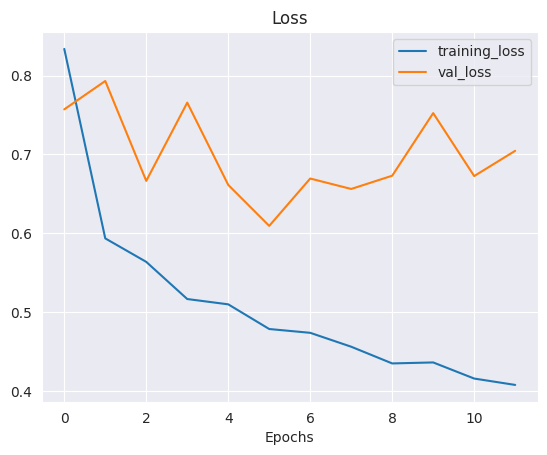

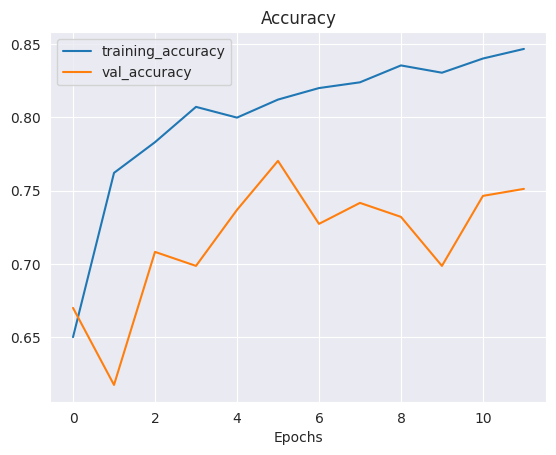

In [116]:
plot_loss_curves(efficient_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 1s 143ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.91      0.88        53
           1       0.89      0.73      0.80        56
           2       1.00      0.50      0.67        52
           3       0.60      0.96      0.74        55

    accuracy                           0.78       216
   macro avg       0.84      0.78      0.77       216
weighted avg       0.84      0.78      0.77       216

Specificity: [0.2857142857142857, 0.2342857142857143, 0.1368421052631579, 0.32515337423312884]
Mean Squared Error: : 0.1340850293636322
The average AUC-ROC is 0.936801295340743


[0.96875,
 0.6882352941176471,
 0.7210526315789474,
 0.625,
 0.65,
 0.9117647058823529,
 0.7052631578947368,
 0.6796875,
 0.71875,
 0.7176470588235294,
 0.8631578947368421,
 0.7109375,
 0.6625,
 0.6823529411764706,
 0.7105263157894737,
 0.984375]

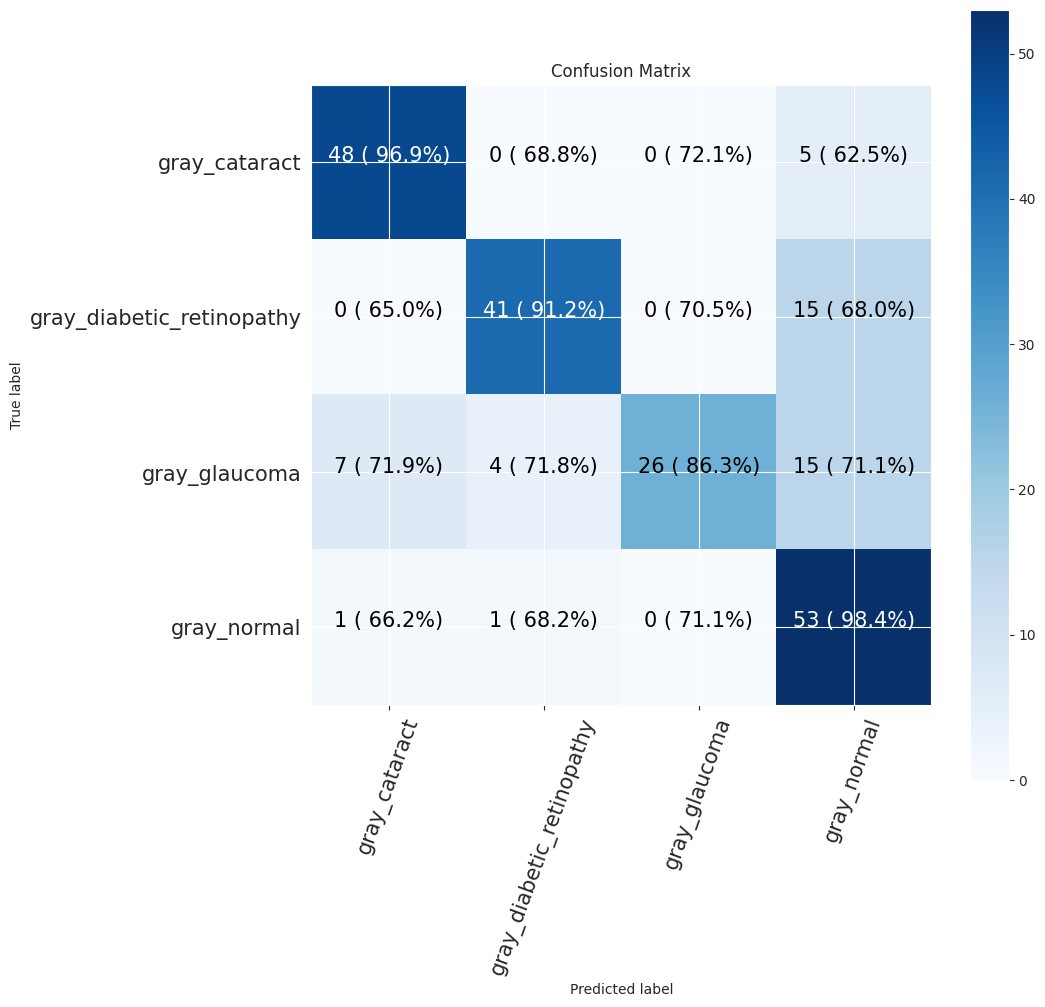

In [117]:
# Save Model
efficient_model.save("efficient_model.h5")

model = efficient_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


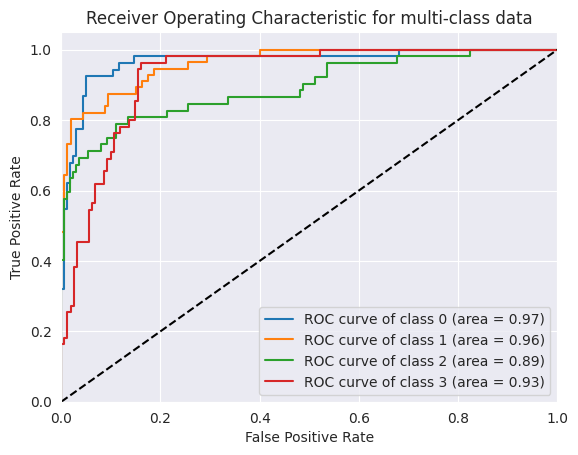

In [118]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **CNN model**

In [119]:
from tensorflow.keras.models import Sequential

# Create a Sequential model
cnn_model = Sequential()

# Add convolutional layers for feature extraction
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))  # Grayscale image has 1 channel

# Freeze the layers in the base model
for layer in cnn_model.layers:
    layer.trainable = False

grayscale_input = layers.Input(shape=(224, 224, 1))

grayscale_input = data_aug(grayscale_input)

cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output for dense layers
cnn_model.add(layers.Flatten())

# Add dense layers for classification
cnn_model.add(layers.Dense(512, activation='relu'))
cnn_model.add(layers.Dense(256, activation='relu'))
cnn_model.add(layers.Dense(4, activation='softmax'))  # Set num_classes to your specific number of classes

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
cnn_model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 26, 26, 128)      

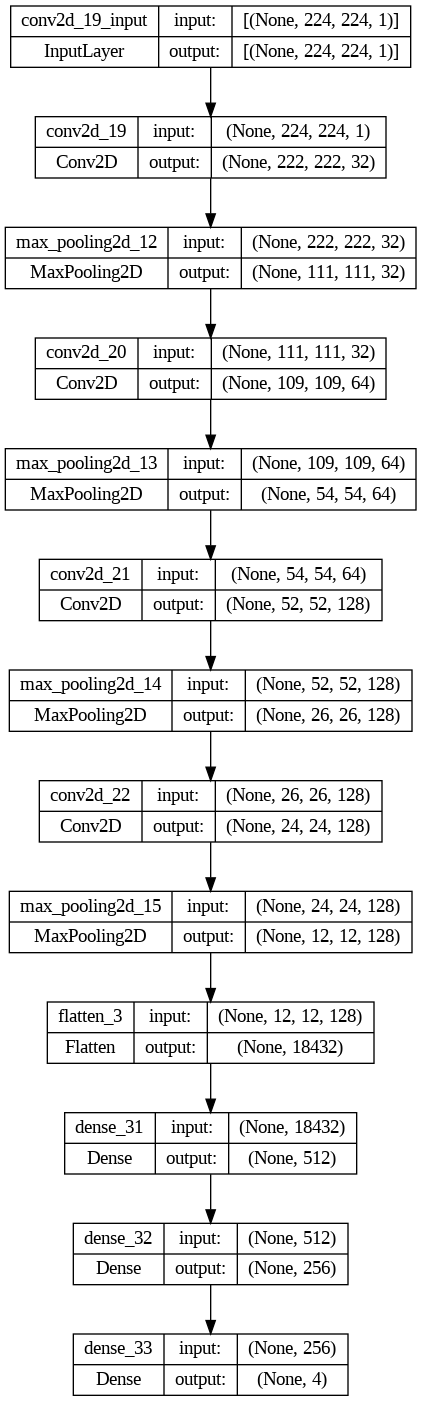

In [120]:
tf.keras.utils.plot_model(cnn_model, show_shapes=True)

In [121]:
cnn_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [122]:
cnn_history = cnn_model.fit(train_data,epochs = epoch, validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
60/60 [==============================] - 10s 90ms/step - loss: 5.8694 - accuracy: 0.4886 - val_loss: 0.9951 - val_accuracy: 0.6029 - lr: 0.0010
Epoch 2/20
60/60 [==============================] - 4s 64ms/step - loss: 0.7156 - accuracy: 0.6945 - val_loss: 0.7127 - val_accuracy: 0.6507 - lr: 0.0010
Epoch 3/20
60/60 [==============================] - 4s 63ms/step - loss: 0.5657 - accuracy: 0.7624 - val_loss: 0.6902 - val_accuracy: 0.6890 - lr: 0.0010
Epoch 4/20
60/60 [==============================] - 4s 64ms/step - loss: 0.5491 - accuracy: 0.7784 - val_loss: 0.5626 - val_accuracy: 0.7990 - lr: 0.0010
Epoch 5/20
60/60 [==============================] - 4s 63ms/step - loss: 0.4879 - accuracy: 0.7957 - val_loss: 0.4815 - val_accuracy: 0.7847 - lr: 0.0010
Epoch 6/20
60/60 [==============================] - 4s 64ms/step - loss: 0.4300 - accuracy: 0.8196 - val_loss: 0.4208 - val_accuracy: 0.8038 - lr: 0.0010
Epoch 7/20
60/60 [==============================] - 4s 63ms/step - loss: 0.

CNN Evaluation

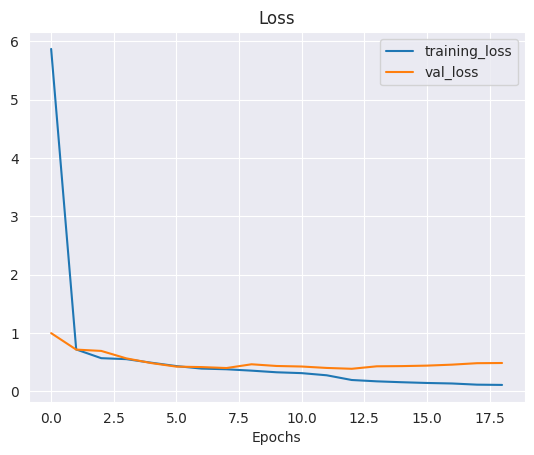

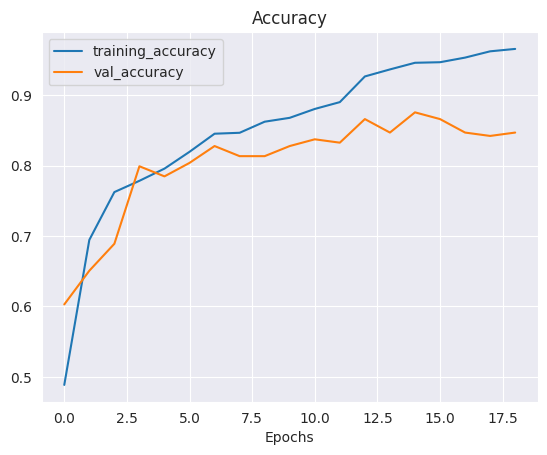

In [123]:
plot_loss_curves(cnn_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 0s 24ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.81      0.80        53
           1       1.00      0.98      0.99        56
           2       0.74      0.62      0.67        52
           3       0.76      0.87      0.81        55

    accuracy                           0.82       216
   macro avg       0.82      0.82      0.82       216
weighted avg       0.82      0.82      0.82       216

Specificity: [0.24855491329479767, 0.3416149068322981, 0.17391304347826086, 0.2857142857142857]
Mean Squared Error: : 0.11939378082752228
The average AUC-ROC is 0.9524329827459869


[0.937888198757764,
 0.6708074534161491,
 0.7341040462427746,
 0.673202614379085,
 0.6521739130434783,
 0.9937888198757764,
 0.6763005780346821,
 0.6405228758169934,
 0.7329192546583851,
 0.6770186335403726,
 0.884393063583815,
 0.7320261437908496,
 0.6770186335403726,
 0.6583850931677019,
 0.7052023121387283,
 0.954248366013072]

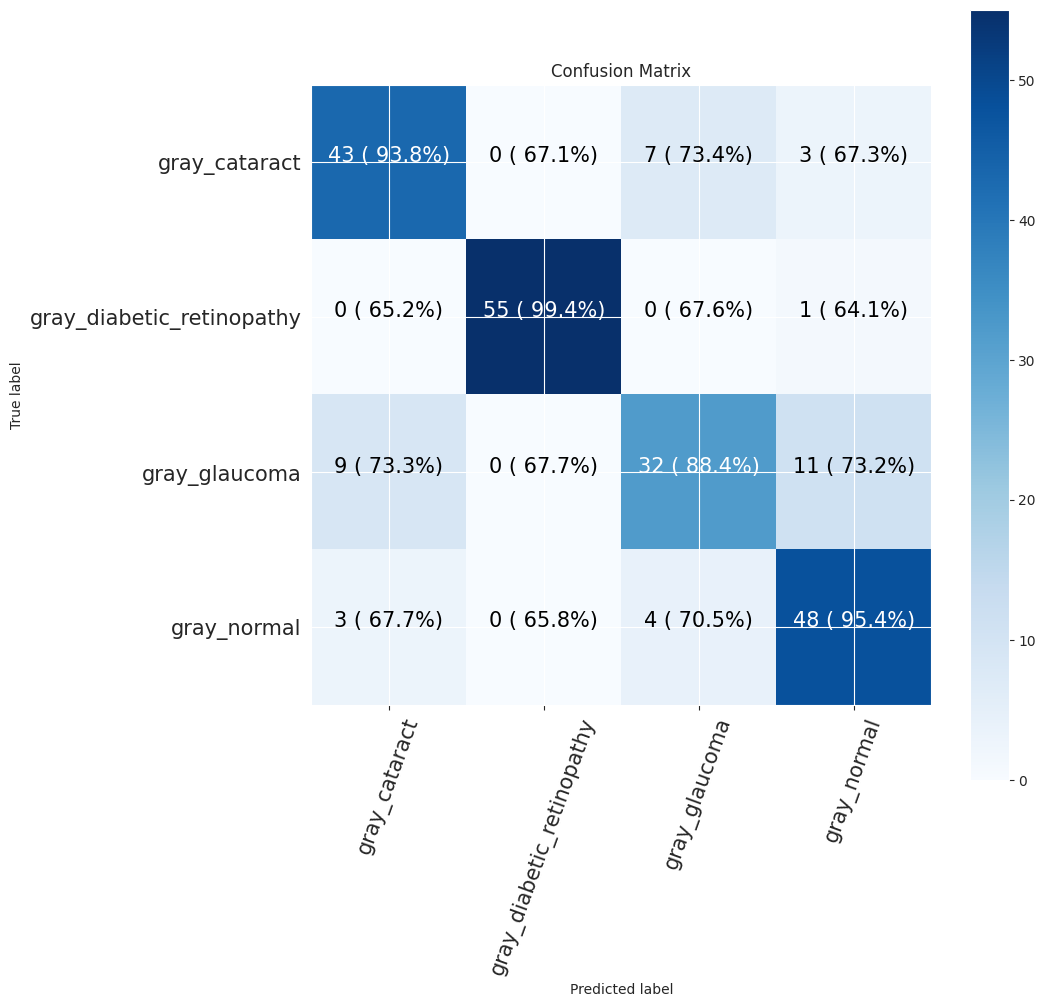

In [124]:
# Save Model
cnn_model.save("cnn_model.h5")

model = cnn_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


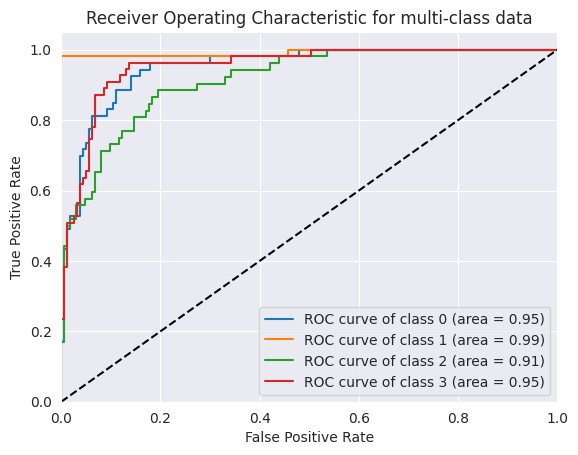

In [125]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet50 Model**



In [126]:
from tensorflow.keras.applications import ResNet50

# Load ResNet-50 without the top classification layers (include_top=False)
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet50_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))

# grayscale_input = Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)
# Convert grayscale to 3 channels (matching the input requirement of ResNet-50)
conv_layer = Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-50 model
x = resnet50_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = layers.Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-50 model for grayscale images
resnet50_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet50_model.summary()


Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_32 (InputLayer)       [(None, None, None, 1)]   0         
                                                                 
 conv2d_23 (Conv2D)          (None, None, None, 3)     30        
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
 1 (GlobalAveragePooling2D)                                      
                                                                 
 dense_34 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_35 (Dense)            (None, 4)                 4100      
                                                          

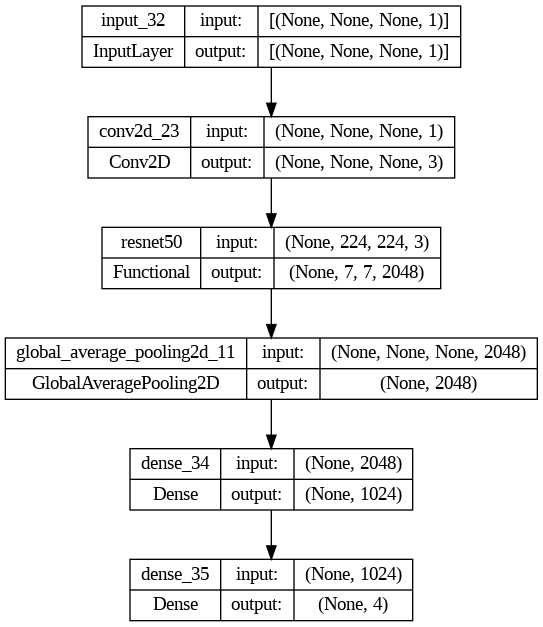

In [127]:
tf.keras.utils.plot_model(resnet50_model, show_shapes=True)

In [128]:
resnet50_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [129]:
resnet50_history = resnet50_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
60/60 [==============================] - 49s 600ms/step - loss: 0.9542 - accuracy: 0.7157 - val_loss: 0.4203 - val_accuracy: 0.8278 - lr: 0.0010
Epoch 2/20
60/60 [==============================] - 29s 486ms/step - loss: 0.3501 - accuracy: 0.8720 - val_loss: 0.3889 - val_accuracy: 0.8421 - lr: 0.0010
Epoch 3/20
60/60 [==============================] - 29s 486ms/step - loss: 0.2915 - accuracy: 0.8906 - val_loss: 0.3088 - val_accuracy: 0.8660 - lr: 0.0010
Epoch 4/20
60/60 [==============================] - 30s 490ms/step - loss: 0.2582 - accuracy: 0.9043 - val_loss: 0.2794 - val_accuracy: 0.8756 - lr: 0.0010
Epoch 5/20
60/60 [==============================] - 29s 487ms/step - loss: 0.2107 - accuracy: 0.9211 - val_loss: 0.2676 - val_accuracy: 0.8804 - lr: 0.0010
Epoch 6/20
60/60 [==============================] - 29s 487ms/step - loss: 0.1841 - accuracy: 0.9313 - val_loss: 0.2449 - val_accuracy: 0.8756 - lr: 0.0010
Epoch 7/20
60/60 [==============================] - 29s 488ms/st

ResNet50 Evaluation

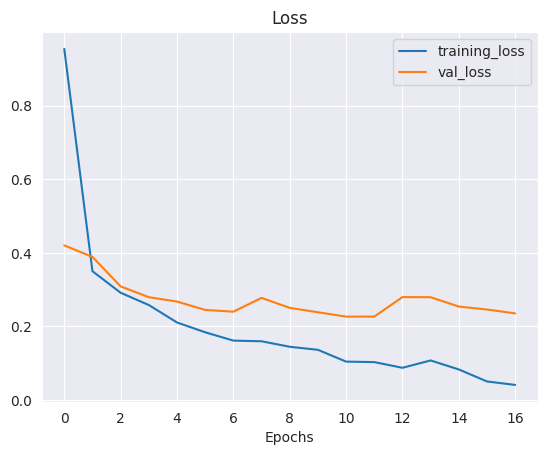

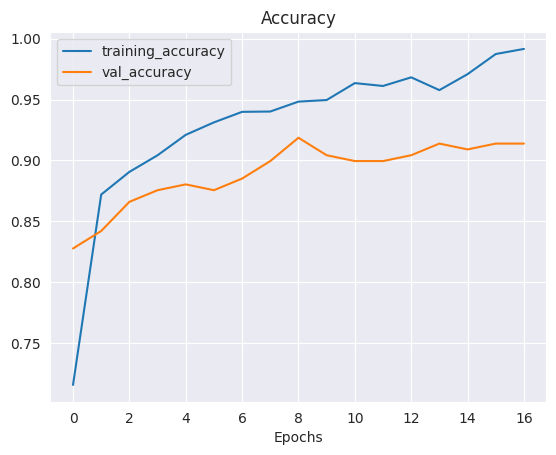

In [130]:
plot_loss_curves(resnet50_history)

4/4 [==============================] - 1s 172ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.98      0.93        53
           1       1.00      1.00      1.00        56
           2       0.95      0.81      0.88        52
           3       0.89      0.93      0.91        55

    accuracy                           0.93       216
   macro avg       0.93      0.93      0.93       216
weighted avg       0.93      0.93      0.93       216

Specificity: [0.3170731707317073, 0.35, 0.2413793103448276, 0.3090909090909091]
Mean Squared Error: : 0.10459598153829575
The average AUC-ROC is 0.9883221580887069


[0.9936305732484076,
 0.66875,
 0.6918604651162791,
 0.6729559748427673,
 0.643312101910828,
 1.0,
 0.6744186046511628,
 0.6477987421383647,
 0.7006369426751592,
 0.675,
 0.9418604651162791,
 0.7044025157232704,
 0.6624203821656051,
 0.65625,
 0.6918604651162791,
 0.9748427672955975]

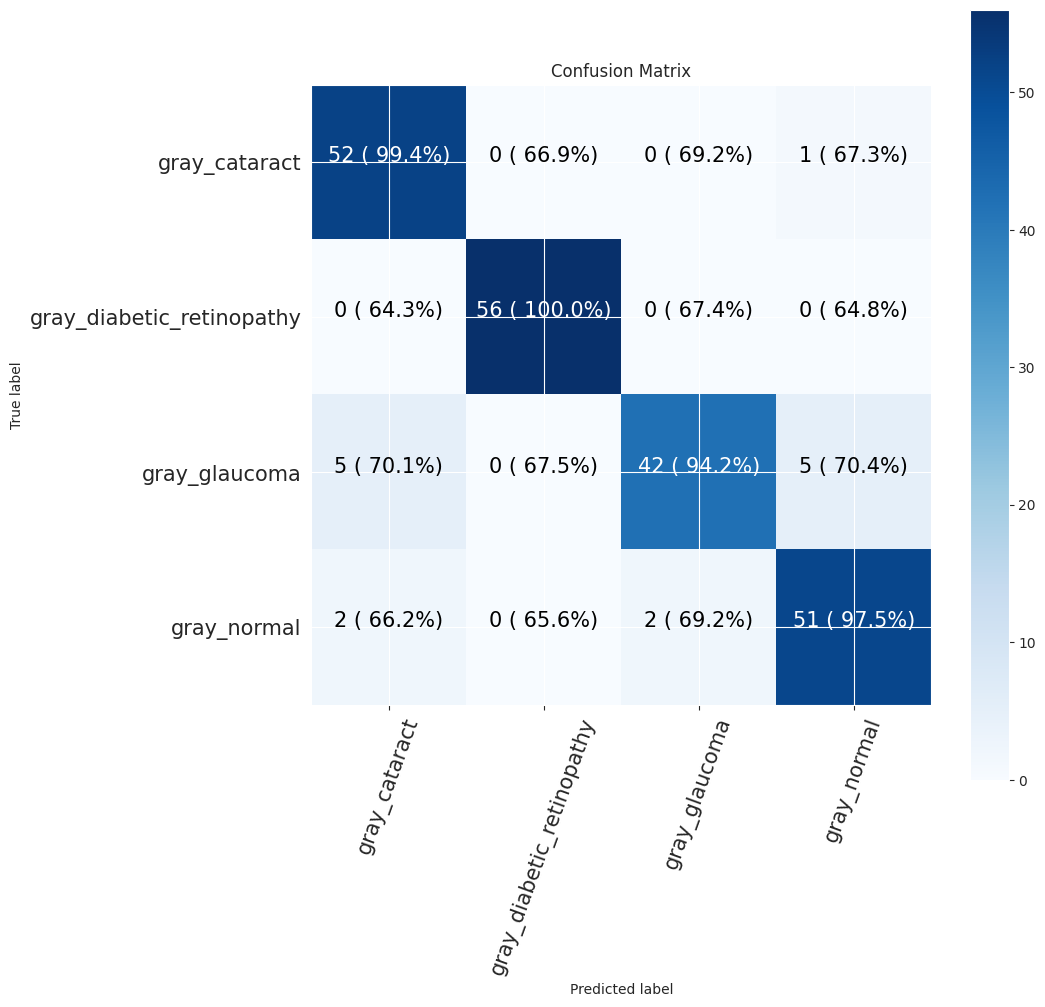

In [132]:
# Save Model
resnet50_model.save("resnet50_model.h5")

model = resnet50_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


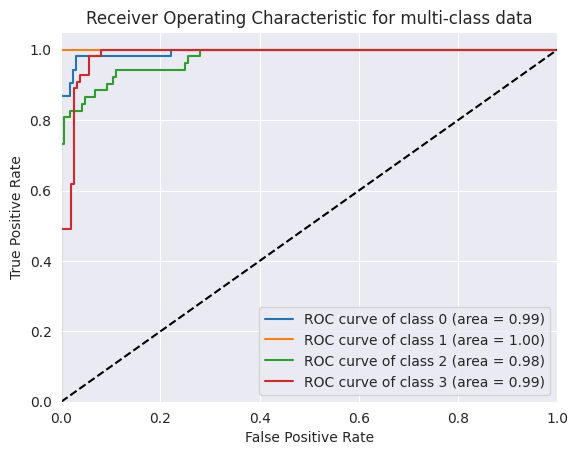

In [133]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet101**

In [134]:
from tensorflow.keras.applications import ResNet101

# Load ResNet-101 without the top classification layers (include_top=False)
resnet101_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet101_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)

# Convert grayscale to 3 channels (matching the input requirement of ResNet-101)
conv_layer = layers.Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-101 model
x = resnet101_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-101 model for grayscale images
resnet101_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet101_model.summary()


Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_35 (InputLayer)       [(None, None, None, 1)]   0         
                                                                 
 conv2d_24 (Conv2D)          (None, None, None, 3)     30        
                                                                 
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
 2 (GlobalAveragePooling2D)                                      
                                                                 
 dense_36 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_37 (Dense)            (None, 4)                 4100      
                                                          

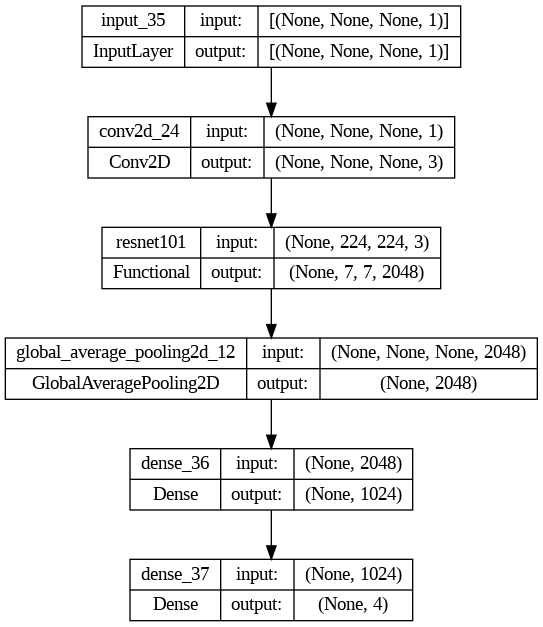

In [135]:
tf.keras.utils.plot_model(resnet101_model, show_shapes=True)

In [136]:
resnet101_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [137]:
resnet101_history= resnet101_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
60/60 [==============================] - 58s 840ms/step - loss: 0.7185 - accuracy: 0.7550 - val_loss: 0.3860 - val_accuracy: 0.8517 - lr: 0.0010
Epoch 2/20
60/60 [==============================] - 48s 791ms/step - loss: 0.3707 - accuracy: 0.8573 - val_loss: 0.3701 - val_accuracy: 0.8421 - lr: 0.0010
Epoch 3/20
60/60 [==============================] - 48s 796ms/step - loss: 0.3025 - accuracy: 0.8862 - val_loss: 0.3329 - val_accuracy: 0.8469 - lr: 0.0010
Epoch 4/20
60/60 [==============================] - 48s 793ms/step - loss: 0.2537 - accuracy: 0.9066 - val_loss: 0.3122 - val_accuracy: 0.8517 - lr: 0.0010
Epoch 5/20
60/60 [==============================] - 48s 794ms/step - loss: 0.2193 - accuracy: 0.9197 - val_loss: 0.2951 - val_accuracy: 0.8660 - lr: 0.0010
Epoch 6/20
60/60 [==============================] - 48s 795ms/step - loss: 0.2050 - accuracy: 0.9218 - val_loss: 0.3148 - val_accuracy: 0.8660 - lr: 0.0010
Epoch 7/20
60/60 [==============================] - 48s 796ms/st

ResNet101 Evaluation

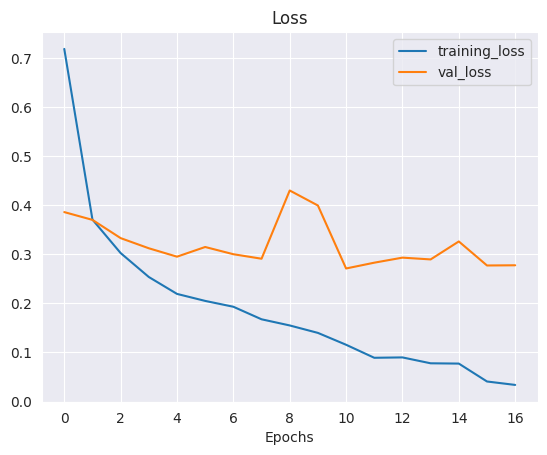

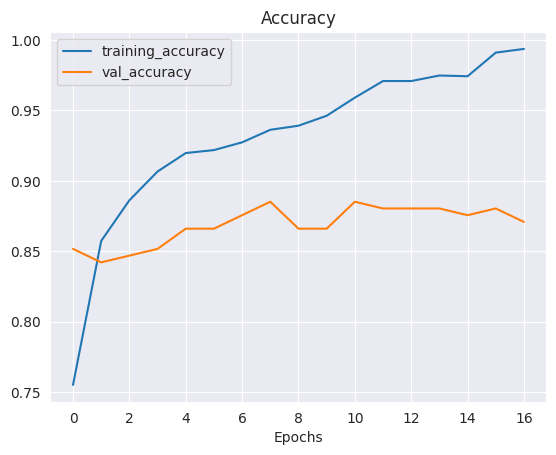

In [138]:
plot_loss_curves(resnet101_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 1s 288ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90        53
           1       1.00      1.00      1.00        56
           2       0.86      0.85      0.85        52
           3       0.91      0.91      0.91        55

    accuracy                           0.92       216
   macro avg       0.92      0.92      0.92       216
weighted avg       0.92      0.92      0.92       216

Specificity: [0.2857142857142857, 0.35, 0.2558139534883721, 0.30120481927710846]
Mean Squared Error: : 0.10578799992799759
The average AUC-ROC is 0.986945953601175


[0.9691358024691358,
 0.66875,
 0.703030303030303,
 0.6770186335403726,
 0.654320987654321,
 1.0,
 0.6606060606060606,
 0.6521739130434783,
 0.7037037037037037,
 0.675,
 0.9515151515151515,
 0.7018633540372671,
 0.6728395061728395,
 0.65625,
 0.6848484848484848,
 0.968944099378882]

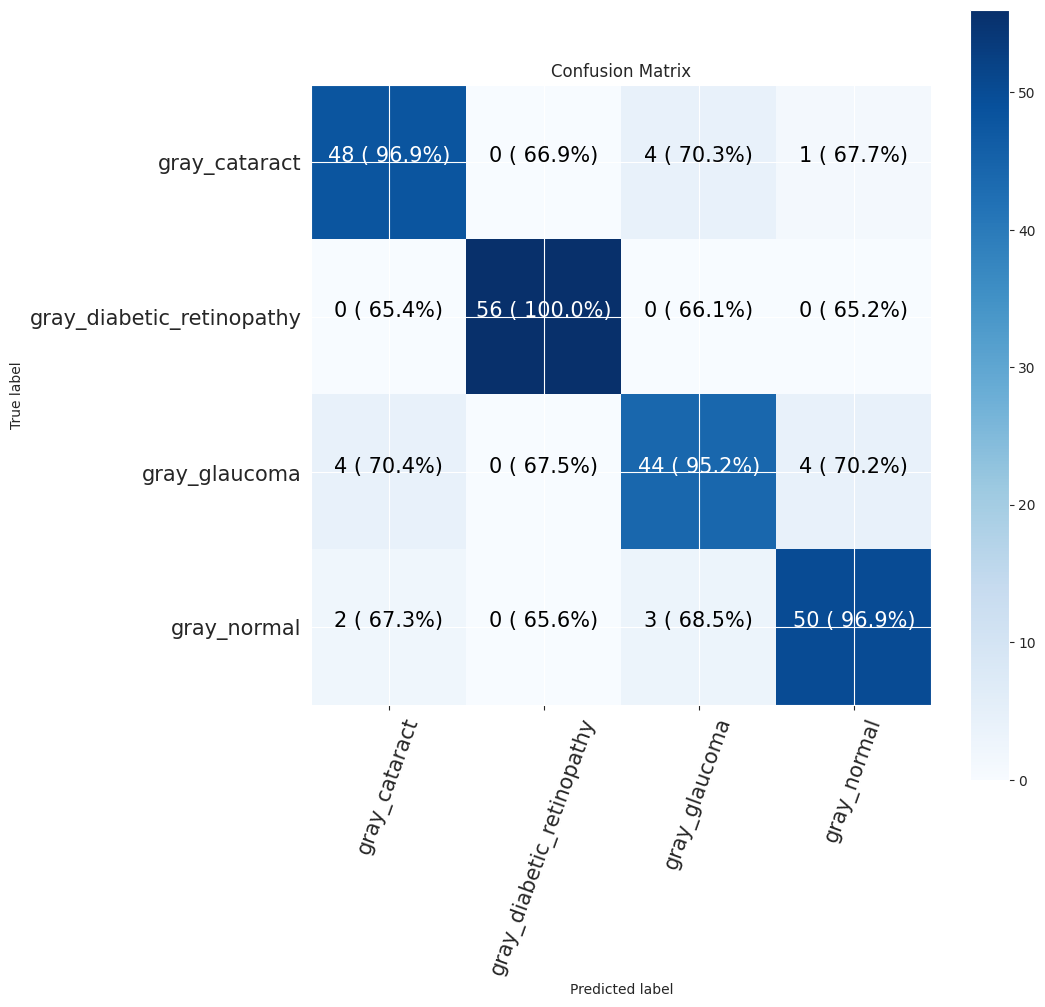

In [139]:
# Save Model
resnet101_model.save("resnet101_model.h5")

model = resnet101_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


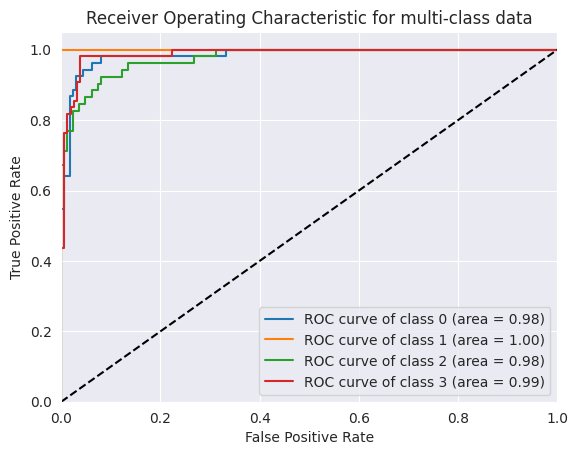

In [140]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()